<a href="https://colab.research.google.com/github/AkshNaidu/single_cell_analysis/blob/main/single_cell_one_ipnyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install Seurat (only run once)
install.packages('Seurat')
install.packages('dplyr')
install.packages('ggplot2')
install.packages('patchwork')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘dotCall64’, ‘gtools’, ‘caTools’, ‘plyr’, ‘tensor’, ‘BH’, ‘sitmo’, ‘sp’, ‘spam’, ‘globals’, ‘listenv’, ‘parallelly’, ‘zoo’, ‘lazyeval’, ‘crosstalk’, ‘RcppTOML’, ‘here’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘spatstat.data’, ‘spatstat.univar’, ‘spatstat.random’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘goftest’, ‘abind’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘dqrng’, ‘SeuratObject’, ‘cowplot’, ‘fastDummies’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘lmtest’, ‘matrixStats’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘progressr’, ‘RANN’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘reticulate’, ‘ROCR’, ‘RSpectra’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘spatstat.explore’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/u

In [4]:
# Load libraries
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [6]:
# Create directories
dir.create("data", showWarnings = FALSE)

In [7]:
# Download the dataset (takes ~1 minute)
download.file(
  url = "https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz",
  destfile = "data/pbmc3k_data.tar.gz"
)

In [8]:
# Load the raw data (10X format)
untar("data/pbmc3k_data.tar.gz", exdir = "data/")

In [9]:
# Check if it worked
list.files("data/filtered_gene_bc_matrices/hg19/")

[1] "barcodes.tsv" "genes.tsv"    "matrix.mtx"

In [10]:
# Load the data (note the updated path!)
pbmc.data <- Read10X(data.dir = "data/filtered_gene_bc_matrices/hg19/")

In [11]:
# Check what you loaded
dim(pbmc.data)

[1] 32738  2700

In [12]:
# Create Seurat object
pbmc <- CreateSeuratObject(counts = pbmc.data,
                           project = "pbmc3k",
                           min.cells = 3,
                           min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [13]:
pbmc

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

In [14]:
# Calculate % of mitochondrial genes (dying cells have high %)
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

# Calculate % of ribosomal genes
pbmc[["percent.ribo"]] <- PercentageFeatureSet(pbmc, pattern = "^RP[SL]")



In [15]:
head(pbmc@meta.data)


orig.ident nCount_RNA nFeature_RNA percent.mt percent.ribo
AAACATACAACCAC-1 pbmc3k     2419        779         3.0177759  43.69574    
AAACATTGAGCTAC-1 pbmc3k     4903       1352         3.7935958  42.40261    
AAACATTGATCAGC-1 pbmc3k     3147       1129         0.8897363  31.68097    
AAACCGTGCTTCCG-1 pbmc3k     2639        960         1.7430845  24.25161    
AAACCGTGTATGCG-1 pbmc3k      980        521         1.2244898  14.89796    
AAACGCACTGGTAC-1 pbmc3k     2163        781         1.6643551  36.19972

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


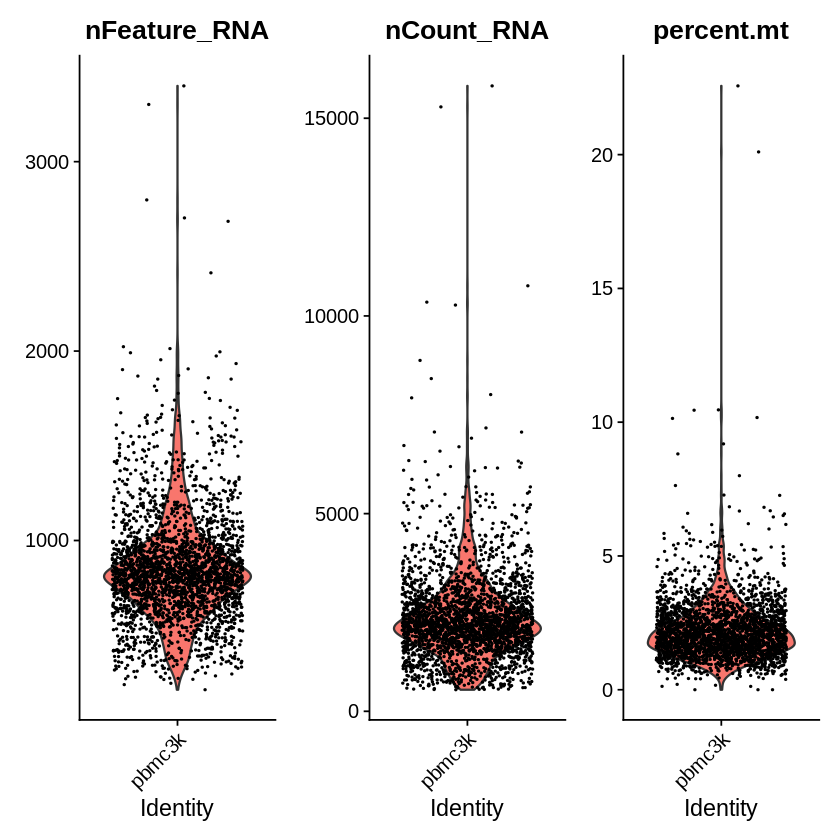

In [16]:
# Visualize QC metrics BEFORE filtering
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

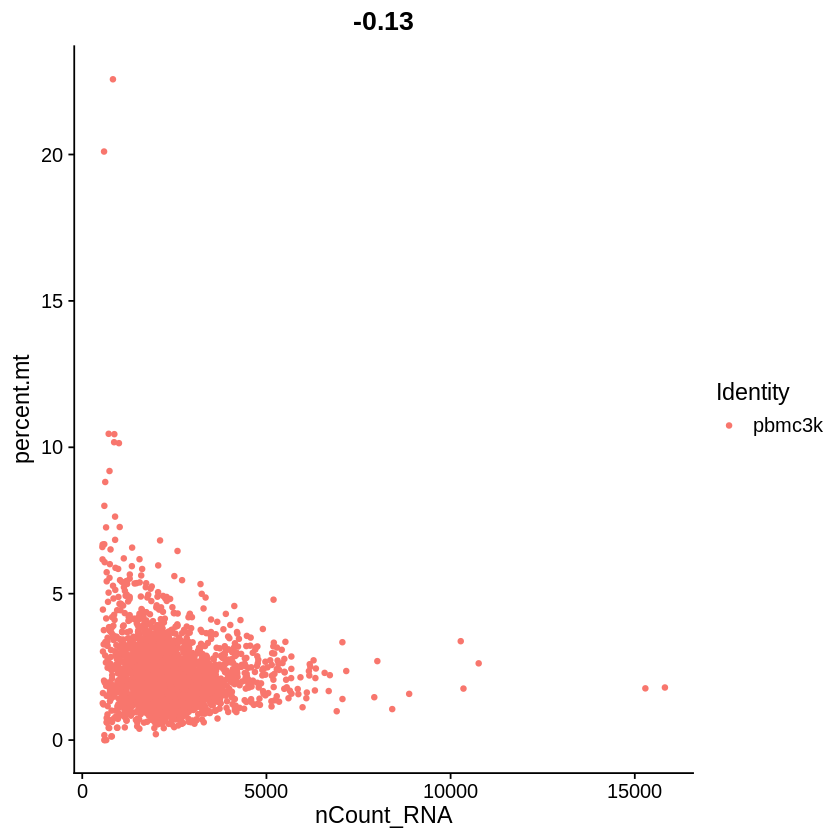

In [17]:
# Scatter plots to see relationships
FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")

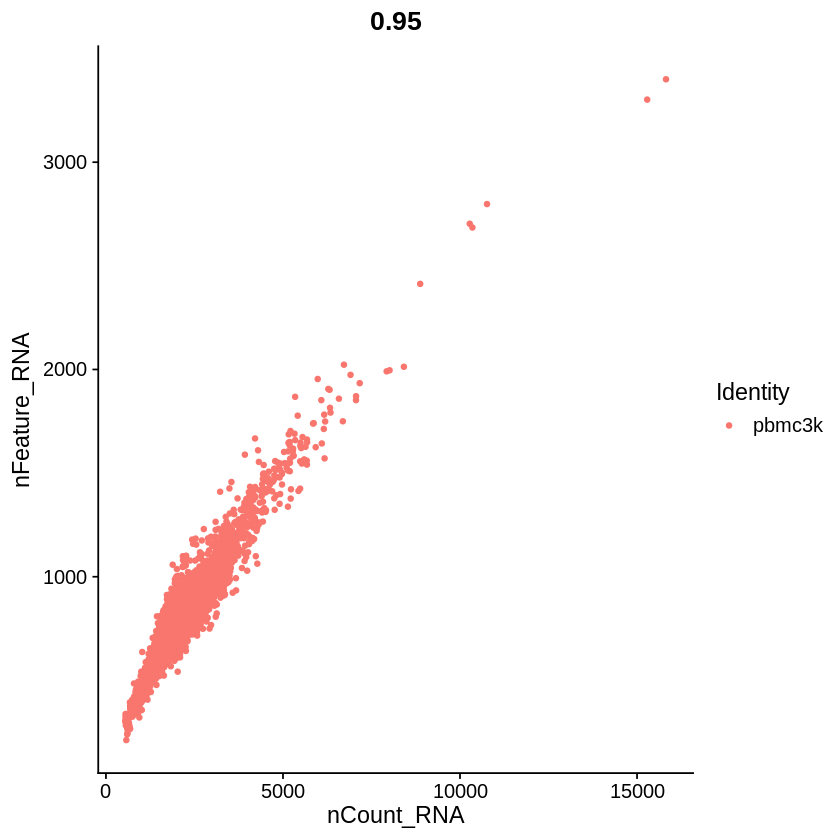

In [18]:
FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [19]:
# Filter: keep cells with 200-2500 genes and <5% mitochondrial content
pbmc <- subset(pbmc,
               subset = nFeature_RNA > 200 &
                        nFeature_RNA < 2500 &
                        percent.mt < 5)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


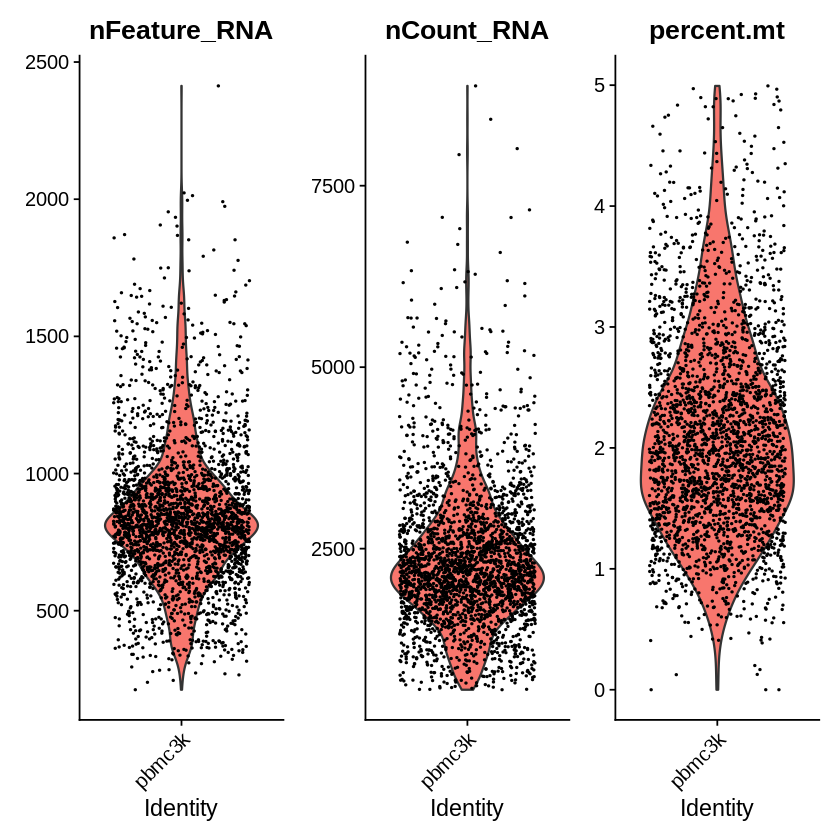

In [20]:
# Visualize QC metrics AFTER filtering
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [21]:
# Log-normalize: makes expression values comparable across cells
pbmc <- NormalizeData(pbmc,
                      normalization.method = "LogNormalize",
                      scale.factor = 10000)

Normalizing layer: counts



In [22]:
# Find the 2000 most variable genes (most informative)
pbmc <- FindVariableFeatures(pbmc,
                              selection.method = "vst",
                              nfeatures = 2000)

Finding variable features for layer counts



In [23]:
# See the top 10 most variable genes
top10 <- head(VariableFeatures(pbmc), 10)
top10

[1] "PPBP"   "LYZ"    "S100A9" "IGLL5"  "GNLY"   "FTL"    "PF4"    "FTH1"  
 [9] "GNG11"  "S100A8"

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


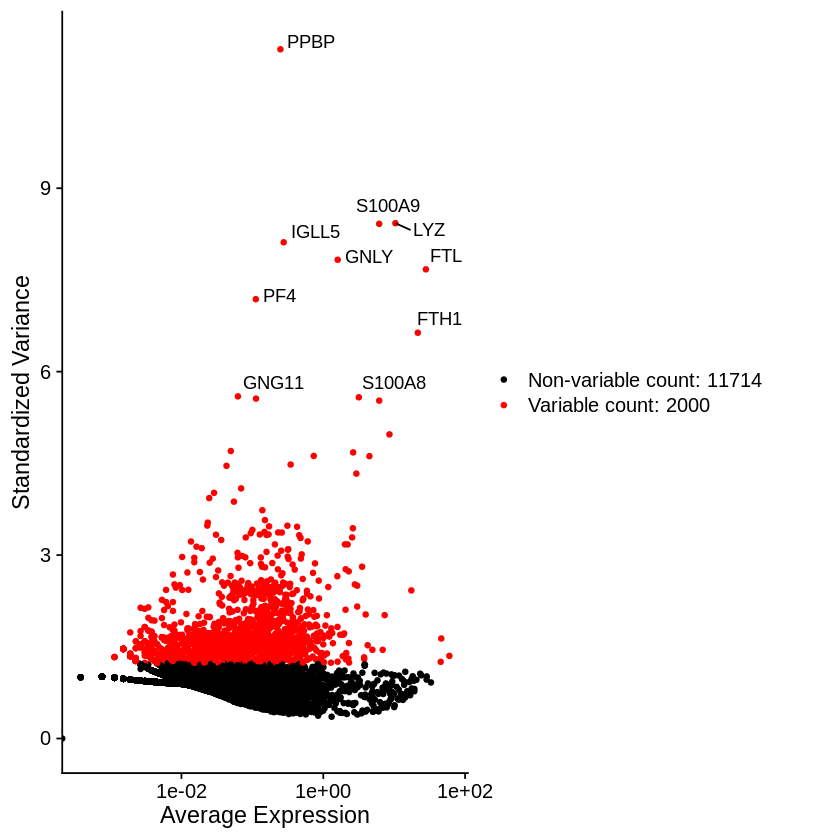

In [24]:
# Plot variable features
plot1 <- VariableFeaturePlot(pbmc)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

In [25]:
# Get all gene names
all.genes <- rownames(pbmc)

In [26]:
# Scale data: mean=0, variance=1 for each gene
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [27]:
# Run PCA using variable genes
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

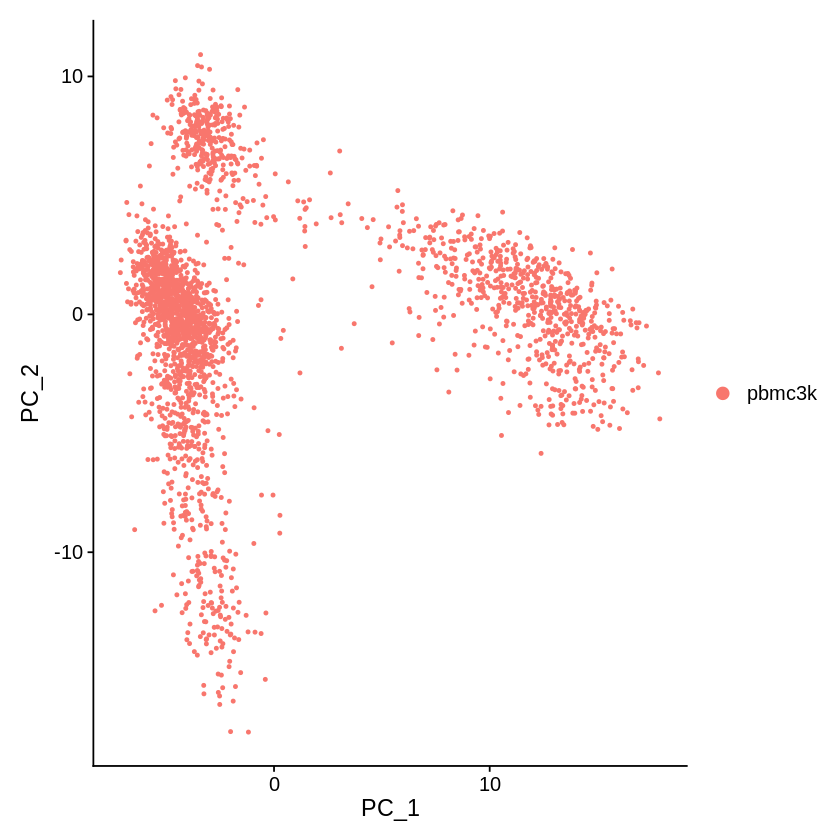

In [28]:
# Visualize PCA
DimPlot(pbmc, reduction = "pca")

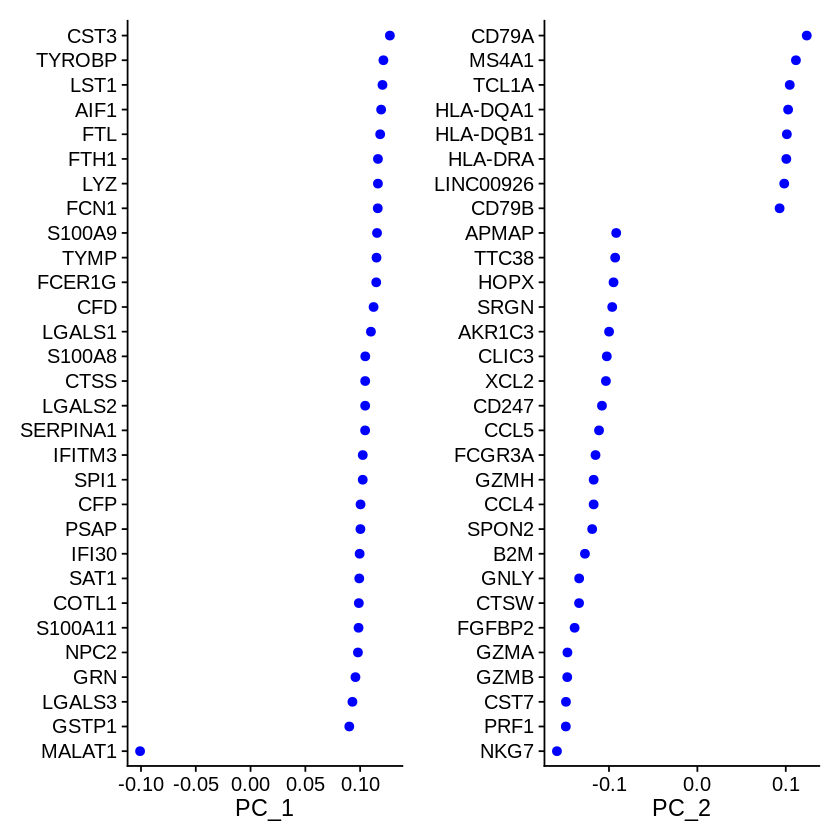

In [29]:
# See which genes contribute to PC1 and PC2
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

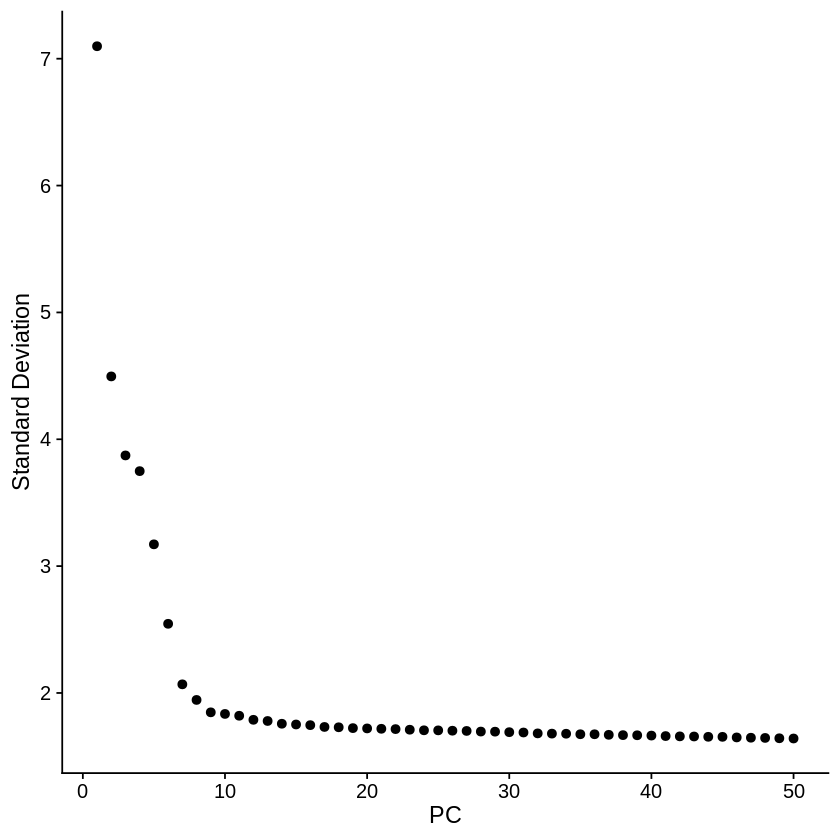

In [30]:
# Elbow plot: helps decide how many PCs to use
ElbowPlot(pbmc, ndims = 50)

In [31]:
# Build nearest neighbor graph (using first 10 PCs)
pbmc <- FindNeighbors(pbmc, dims = 1:10)

Computing nearest neighbor graph

Computing SNN



In [32]:
# Find clusters (resolution = granularity)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


In [33]:
# See how many cells in each cluster
table(Idents(pbmc))


  0   1   2   3   4   5   6   7   8 
711 480 472 344 279 162 144  32  14 

In [34]:
# Run UMAP for 2D visualization
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:59:48 UMAP embedding parameters a = 0.9922 b = 1.112

20:59:48 Read 2638 rows and found 10 numeric columns

20:59:48 Using Annoy for neighbor search, n_neighbors = 30

20:59:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:59:48 Writing NN index file to temp file /tmp/RtmpJTKMR7/file31e12b51f2a

20:59:48 Searching Annoy index using 1 thread, search_k = 3000

20:59:49 Annoy recall = 100%

20:59:49 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

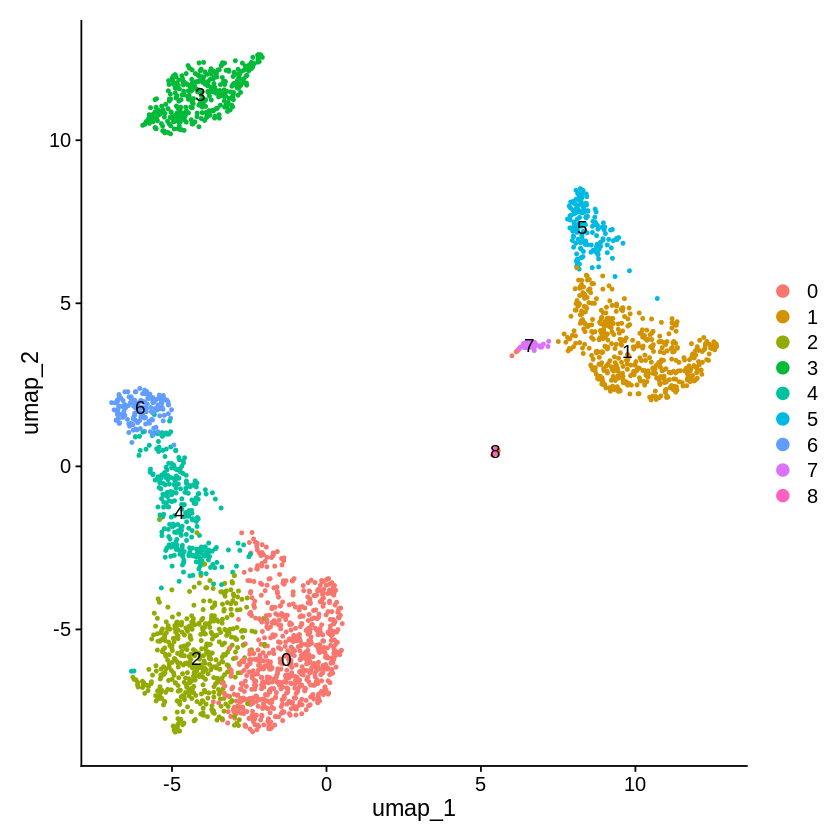

In [35]:
# Plot UMAP with cluster labels
DimPlot(pbmc, reduction = "umap", label = TRUE)

In [36]:
# Find markers for all clusters
pbmc.markers <- FindAllMarkers(pbmc,
                                only.pos = TRUE,
                                min.pct = 0.25,
                                logfc.threshold = 0.25)

Calculating cluster 0

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [37]:
# Look at the results
head(pbmc.markers)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene 
RPS12 1.806317e-144 0.7439459  1.000 0.991 2.477183e-140 0       RPS12
RPS6  7.135900e-142 0.6862148  1.000 0.995 9.786173e-138 0       RPS6 
RPS27 5.257820e-140 0.7298479  0.999 0.992 7.210575e-136 0       RPS27
RPL32 4.229582e-136 0.6184804  0.999 0.995 5.800448e-132 0       RPL32
RPS14 1.799019e-130 0.6283021  1.000 0.994 2.467175e-126 0       RPS14
RPS25 5.507298e-123 0.7635765  0.997 0.975 7.552709e-119 0       RPS25

In [38]:
# Get top 10 markers per cluster
top10_markers <- pbmc.markers %>%
  group_by(cluster) %>%
  top_n(n = 10, wt = avg_log2FC)

In [39]:
# View markers for cluster 0
pbmc.markers %>% filter(cluster == 0) %>% head()

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene 
RPS12 1.806317e-144 0.7439459  1.000 0.991 2.477183e-140 0       RPS12
RPS6  7.135900e-142 0.6862148  1.000 0.995 9.786173e-138 0       RPS6 
RPS27 5.257820e-140 0.7298479  0.999 0.992 7.210575e-136 0       RPS27
RPL32 4.229582e-136 0.6184804  0.999 0.995 5.800448e-132 0       RPL32
RPS14 1.799019e-130 0.6283021  1.000 0.994 2.467175e-126 0       RPS14
RPS25 5.507298e-123 0.7635765  0.997 0.975 7.552709e-119 0       RPS25

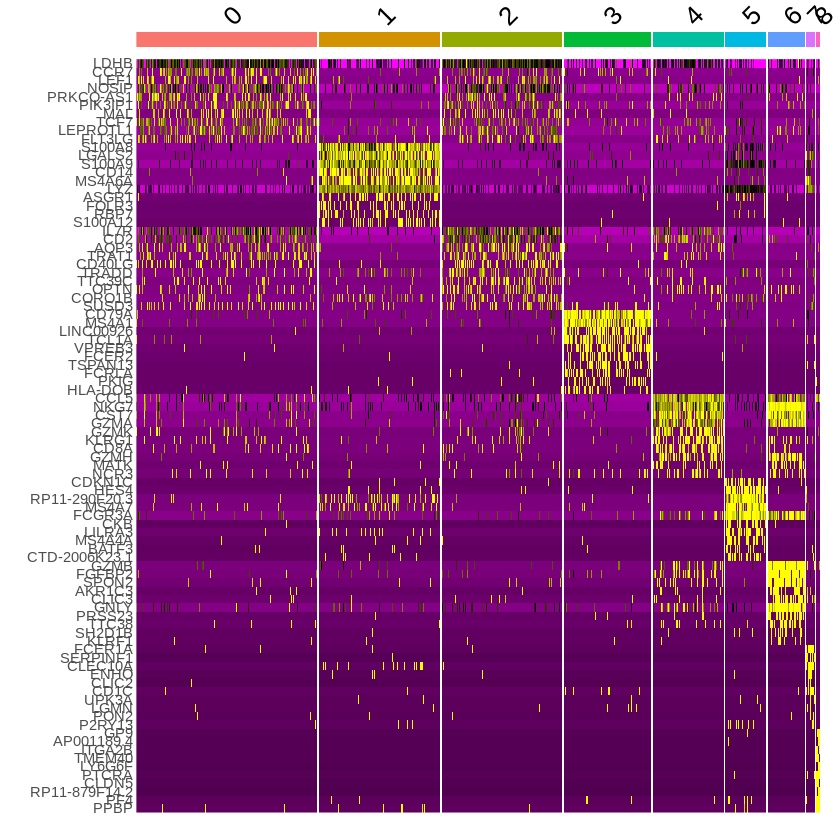

In [40]:
# Heatmap of top markers
DoHeatmap(pbmc, features = top10_markers$gene) + NoLegend()

In [41]:
# Assign cell type names based on markers
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T",
                     "B", "CD8 T", "FCGR3A+ Mono",
                     "NK", "DC", "Platelet")

In [42]:
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)

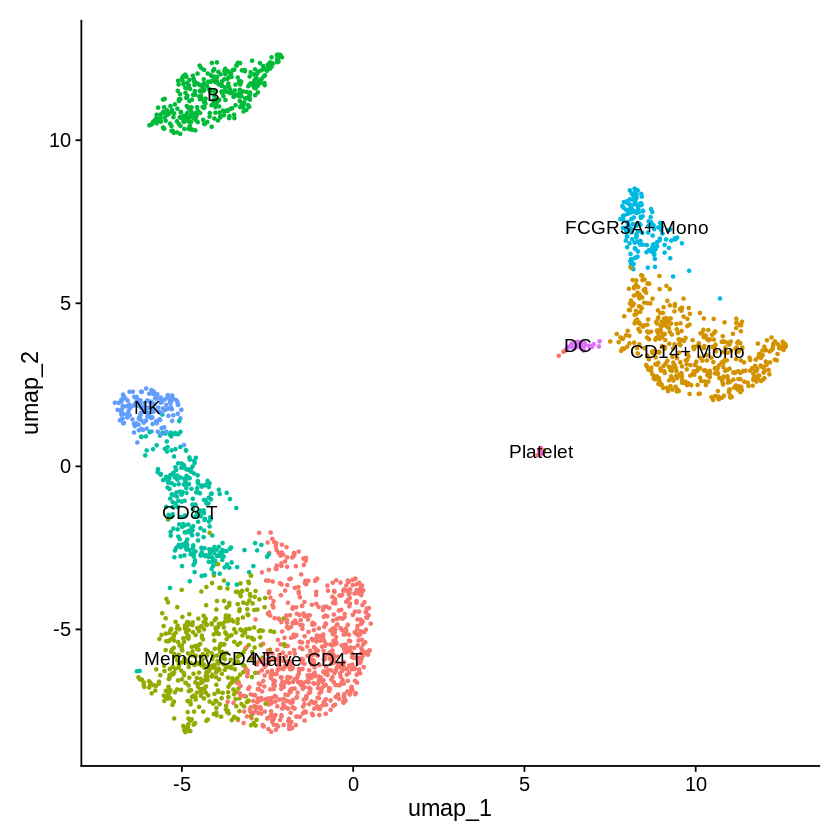

In [43]:
# Plot UMAP with cell type labels
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

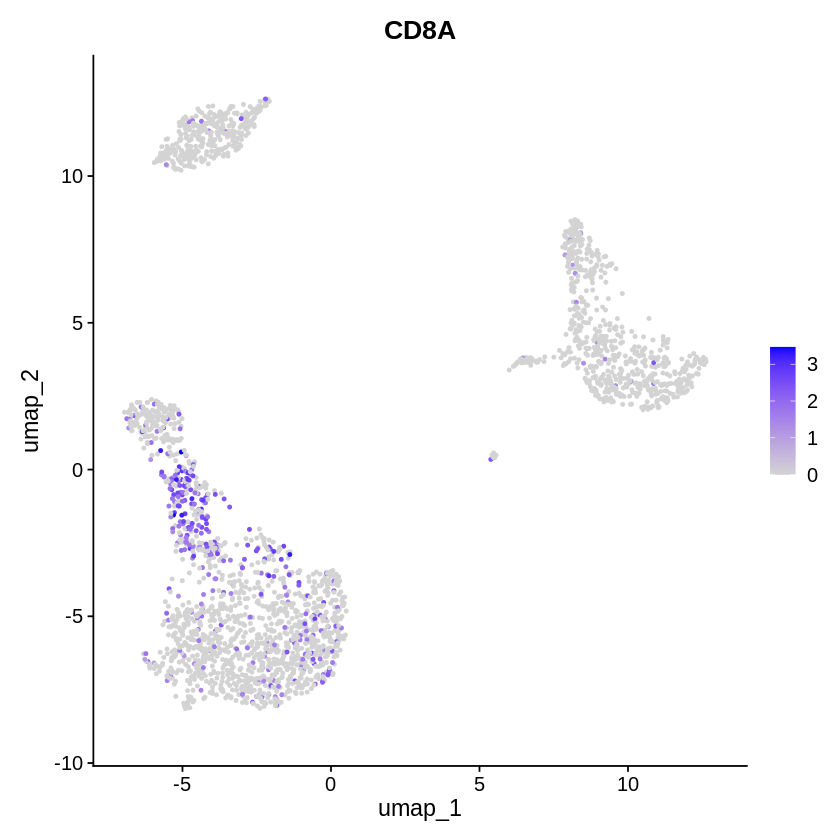

In [44]:
FeaturePlot(pbmc, features = c("CD8A"))  # CD8 T cell marker

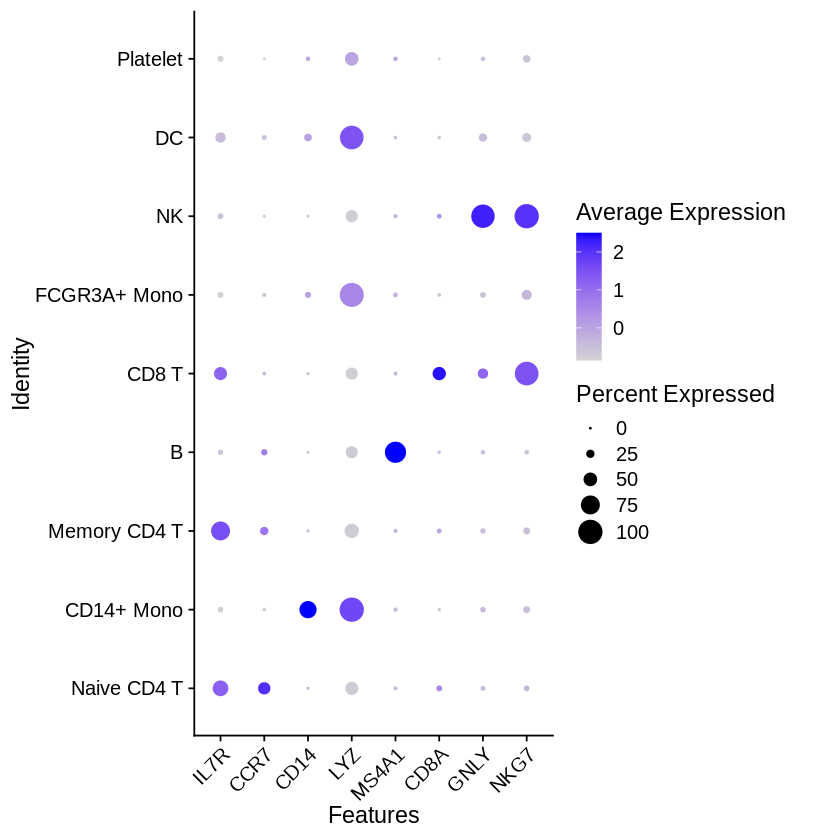

In [45]:
# Dot plot of canonical markers
DotPlot(pbmc, features = c("IL7R", "CCR7", "CD14", "LYZ",
                            "MS4A1", "CD8A", "GNLY", "NKG7")) +
  RotatedAxis()

In [46]:
# Compare two cell types
mono_de <- FindMarkers(pbmc,
                       ident.1 = "CD14+ Mono",
                       ident.2 = "FCGR3A+ Mono")

In [47]:
# Look at top results
head(mono_de)

p_val         avg_log2FC pct.1 pct.2 p_val_adj   
FCGR3A 1.193617e-101 -5.019527  0.131 0.975 1.636926e-97
LYZ     8.134552e-75  2.654926  1.000 0.988 1.115572e-70
RHOC    4.479768e-68 -3.319102  0.162 0.864 6.143554e-64
S100A8  7.471811e-65  4.017063  0.975 0.500 1.024684e-60
S100A9  1.318422e-64  3.395934  0.996 0.870 1.808084e-60
IFITM2  4.821669e-64 -2.227960  0.677 1.000 6.612437e-60

In [48]:
# Count cells per type
table(Idents(pbmc))


 Naive CD4 T   CD14+ Mono Memory CD4 T            B        CD8 T FCGR3A+ Mono 
         711          480          472          344          279          162 
          NK           DC     Platelet 
         144           32           14 

In [49]:
# Calculate percentages
prop.table(table(Idents(pbmc))) * 100


 Naive CD4 T   CD14+ Mono Memory CD4 T            B        CD8 T FCGR3A+ Mono 
  26.9522365   18.1956027   17.8923427   13.0401820   10.5761941    6.1410159 
          NK           DC     Platelet 
   5.4586808    1.2130402    0.5307051 

In [50]:
# Save the Seurat object
saveRDS(pbmc, file = "pbmc_analyzed.rds")

In [51]:
# Load it back later
pbmc <- readRDS("pbmc_analyzed.rds")

In [52]:
# Install Monocle3 and dependencies
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install(c("monocle3", "slingshot", "SingleCellExperiment"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'BiocVersion', 'monocle3', 'slingshot',
  'SingleCellExperiment'

Warning message:
“package ‘monocle3’ is not available for Bioconductor version '3.22'

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
also installing the dependencies ‘XVector’, ‘MatrixGenerics’, ‘Biobase’, ‘IRanges’, ‘Seqinfo’, ‘S4Arrays’, ‘SparseArray’, ‘princurve’, ‘TrajectoryUtils’, ‘S4Vectors’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘GenomicRanges’, ‘DelayedArray’


Old packages: 'knitr', 'selectr', 'tidyr', 'xfun', 'yaml'



In [53]:
table(Idents(pbmc))



 Naive CD4 T   CD14+ Mono Memory CD4 T            B        CD8 T FCGR3A+ Mono 
         711          480          472          344          279          162 
          NK           DC     Platelet 
         144           32           14 

In [54]:
# Extract only monocytes
mono_cells <- subset(pbmc, idents = c("CD14+ Mono", "FCGR3A+ Mono"))

In [55]:
# Check what you got
mono_cells
table(Idents(mono_cells))

An object of class Seurat 
13714 features across 642 samples within 1 assay 
Active assay: RNA (13714 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap


  CD14+ Mono FCGR3A+ Mono 
         480          162 

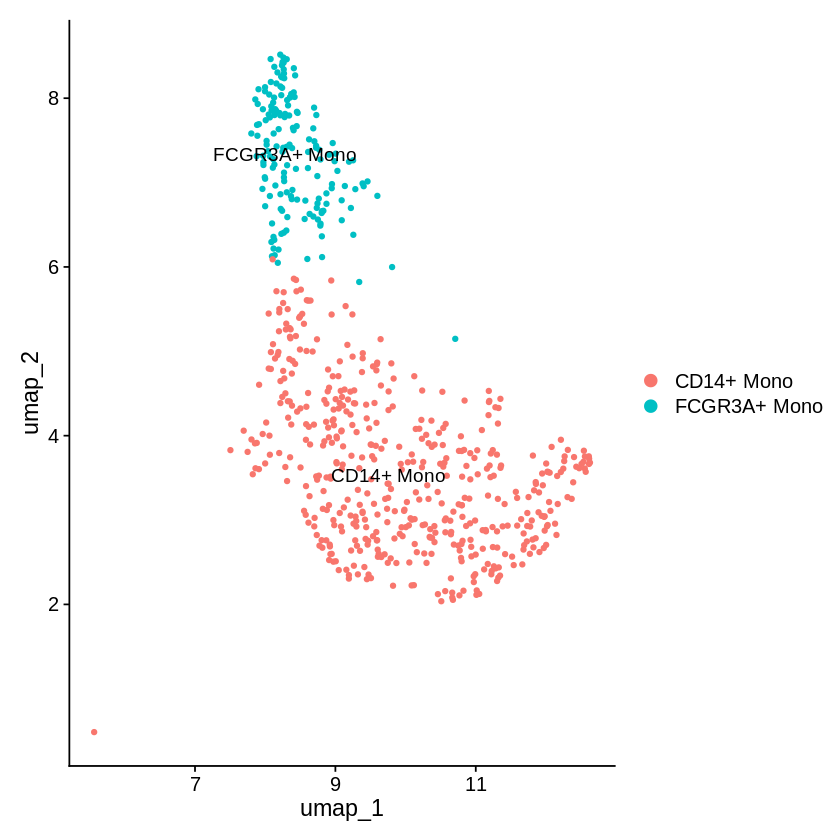

In [56]:
# Visualize monocytes on UMAP
DimPlot(mono_cells, reduction = "umap", label = TRUE, pt.size = 1)

In [59]:
# Install SeuratWrappers (bridges Seurat and Monocle3)
if (!requireNamespace("remotes", quietly = TRUE))
    install.packages("remotes")

remotes::install_github('satijalab/seurat-wrappers')

xfun  (0.54   -> 0.55  ) [CRAN]
yaml  (2.3.11 -> 2.3.12) [CRAN]
knitr (1.50   -> 1.51  ) [CRAN]
tidyr (1.3.1  -> 1.3.2 ) [CRAN]
rsvd  (NA     -> 1.0.5 ) [CRAN]


Installing 5 packages: xfun, yaml, knitr, tidyr, rsvd

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpJTKMR7/remotes31e13e9971f/satijalab-seurat-wrappers-a1eb0d8/DESCRIPTION’ ... OK
* preparing ‘SeuratWrappers’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratWrappers_0.4.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘/tmp/RtmpJTKMR7/file31e60f20c56/SeuratWrappers_0.4.0.tar.gz’ had non-zero exit status”


In [62]:
# Install SeuratWrappers (bridges Seurat and Monocle3)
if (!requireNamespace("SeuratWrappers", quietly = TRUE))
    install.packages("SeuratWrappers")

remotes::install_github('satijalab/SeuratWrappers')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘SeuratWrappers’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


ERROR: Error: Failed to install 'unknown package' from GitHub:
  HTTP error 404.
  Not Found

  Did you spell the repo owner (`satijalab`) and repo name (`SeuratWrappers`) correctly?
  - If spelling is correct, check that you have the required permissions to access the repo.


In [63]:
# Load it
library(SeuratWrappers)

ERROR: Error in library(SeuratWrappers): there is no package called ‘SeuratWrappers’


In [65]:
# Install Slingshot
BiocManager::install("slingshot")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'slingshot'”
Old packages: 'knitr', 'selectr', 'tidyr', 'xfun', 'yaml'



In [66]:
# Load libraries
library(slingshot)
library(SingleCellExperiment)
library(Seurat)
library(ggplot2)

Loading required package: princurve

Loading required package: TrajectoryUtils

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, 

In [67]:
# Subset monocytes from your pbmc object
mono_cells <- subset(pbmc, idents = c("CD14+ Mono", "FCGR3A+ Mono"))

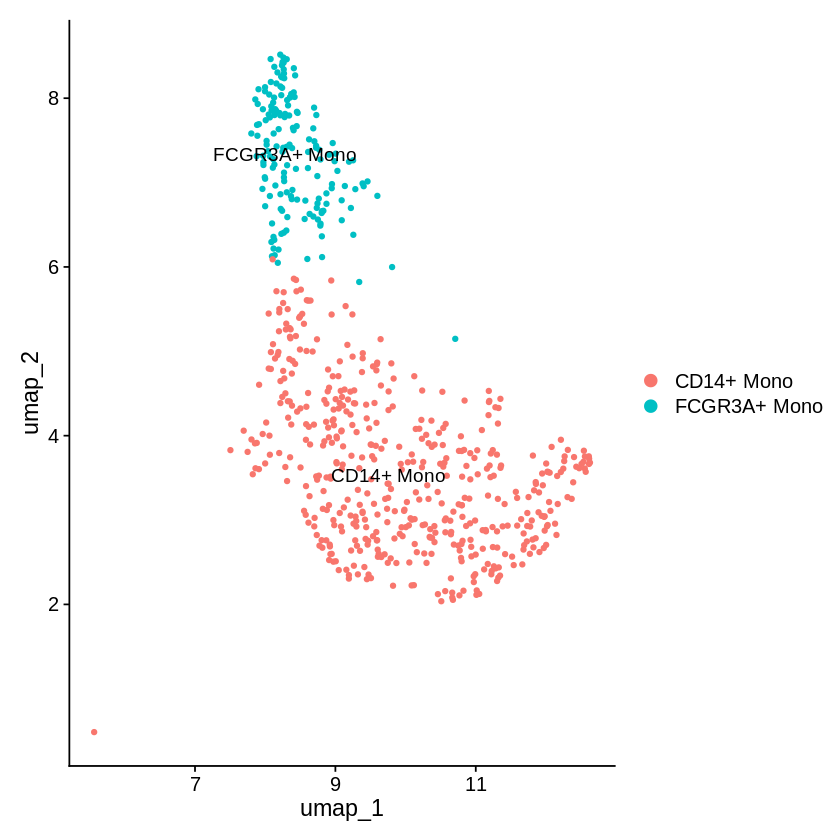

In [68]:
# Check what you have
DimPlot(mono_cells, reduction = "umap", label = TRUE)

In [69]:
# Convert to SingleCellExperiment
mono_sce <- as.SingleCellExperiment(mono_cells)

In [71]:
# Install the missing package
BiocManager::install("DelayedMatrixStats")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'DelayedMatrixStats'

also installing the dependency ‘sparseMatrixStats’


Old packages: 'knitr', 'selectr', 'tidyr', 'xfun', 'yaml'



In [72]:
# Run Slingshot trajectory
mono_sling <- slingshot(mono_sce,
                        clusterLabels = "ident",
                        reducedDim = "UMAP",
                        start.clus = "CD14+ Mono")

In [73]:
# Extract pseudotime (progression along trajectory)
mono_pseudotime <- slingPseudotime(mono_sling)[,1]

In [74]:
# Add pseudotime back to Seurat object
mono_cells$pseudotime <- mono_pseudotime

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


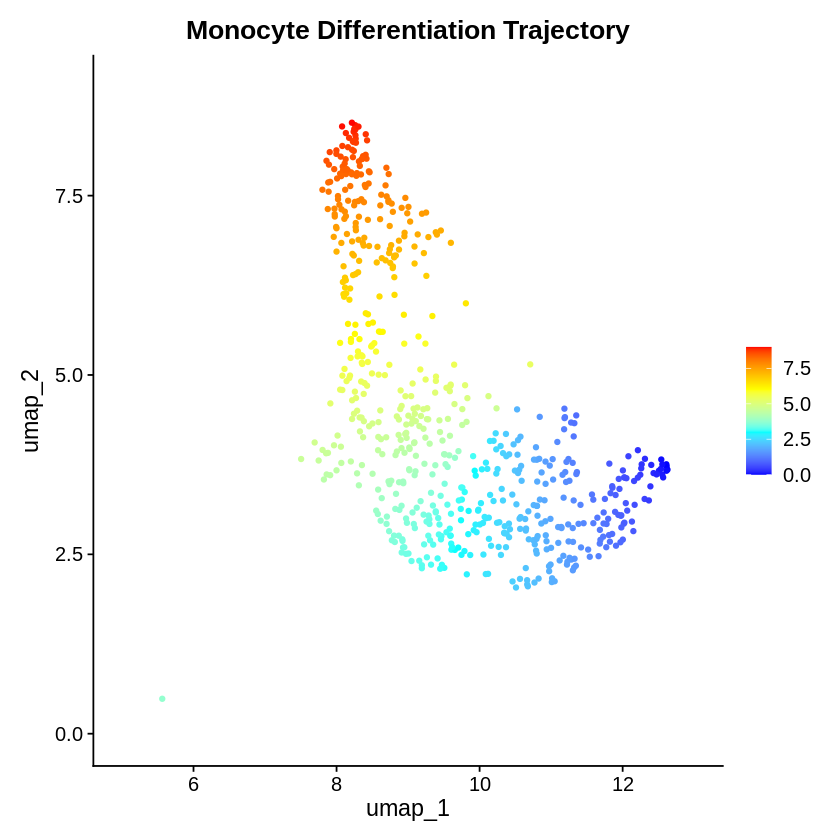

In [75]:
# Visualize pseudotime on UMAP
FeaturePlot(mono_cells,
            features = "pseudotime",
            reduction = "umap") +
  scale_color_gradientn(colors = c("blue", "cyan", "yellow", "red")) +
  ggtitle("Monocyte Differentiation Trajectory")

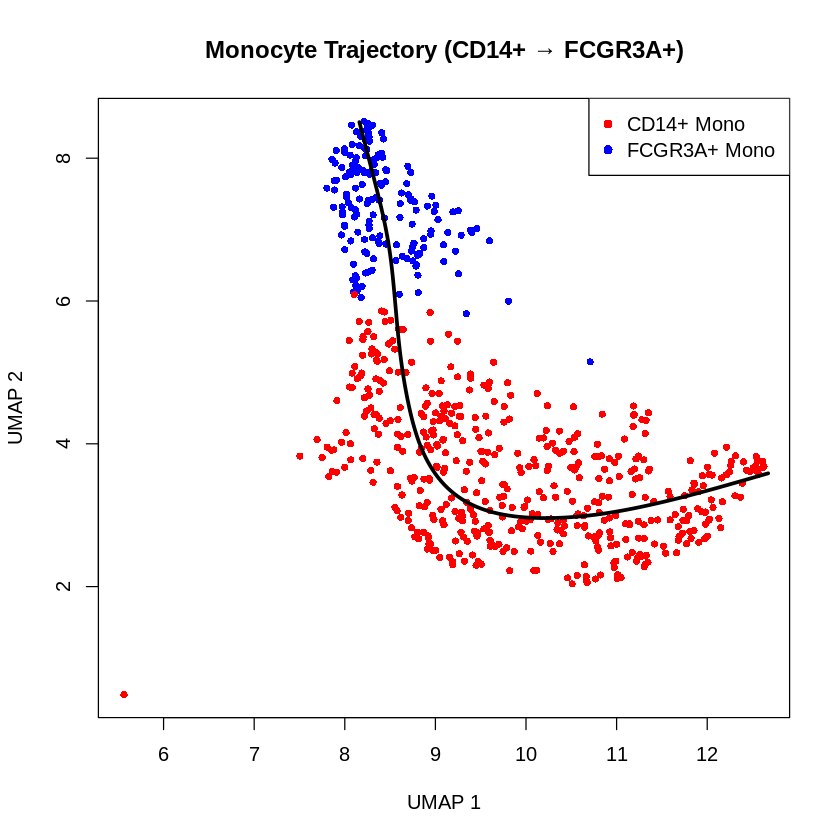

In [76]:
# Plot with trajectory curve overlaid
umap_coords <- Embeddings(mono_cells, "umap")
cell_colors <- c("CD14+ Mono" = "red", "FCGR3A+ Mono" = "blue")

plot(umap_coords,
     col = cell_colors[Idents(mono_cells)],
     pch = 16,
     cex = 0.8,
     main = "Monocyte Trajectory (CD14+ → FCGR3A+)",
     xlab = "UMAP 1",
     ylab = "UMAP 2")

# Add trajectory line
lines(SlingshotDataSet(mono_sling), lwd = 3, col = "black")

# Add legend
legend("topright",
       legend = names(cell_colors),
       col = cell_colors,
       pch = 16)

In [ ]:
##T cells

In [77]:
# Subset T cells
tcell_cells <- subset(pbmc, idents = c("Naive CD4 T", "Memory CD4 T", "CD8 T"))

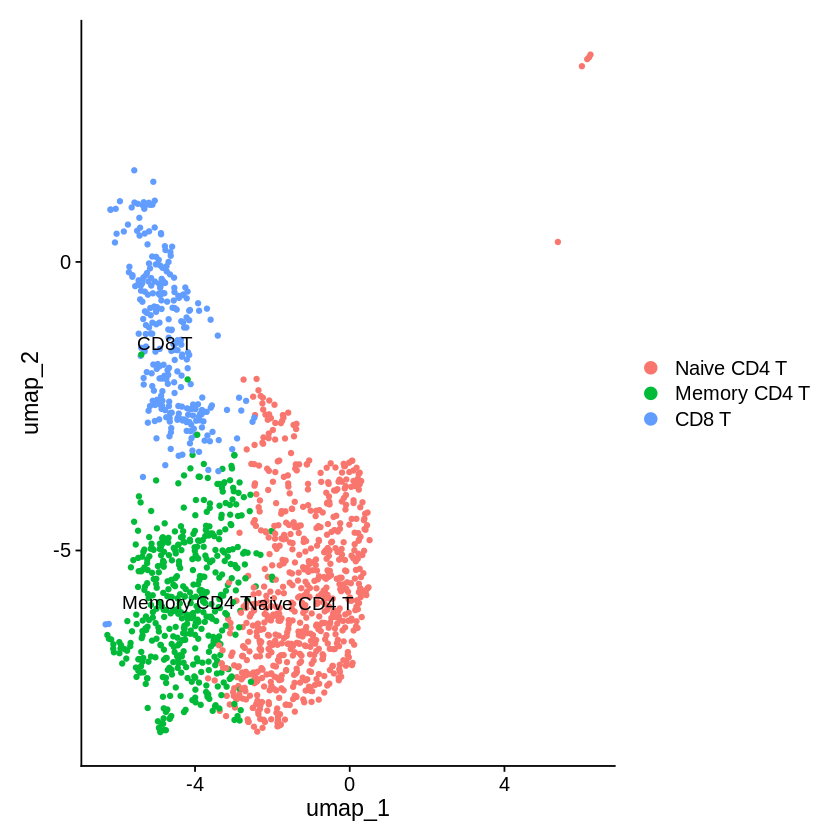

In [78]:
# Check
DimPlot(tcell_cells, reduction = "umap", label = TRUE)

In [80]:
# Check
# Convert to SingleCellExperiment
tcell_sce <- as.SingleCellExperiment(tcell_cells)

In [81]:
# Run Slingshot
tcell_sling <- slingshot(tcell_sce,
                         clusterLabels = "ident",
                         reducedDim = "UMAP",
                         start.clus = "Naive CD4 T")

In [82]:
# Get pseudotime
tcell_pseudotime <- slingPseudotime(tcell_sling)[,1]
tcell_cells$pseudotime <- tcell_pseudotime

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


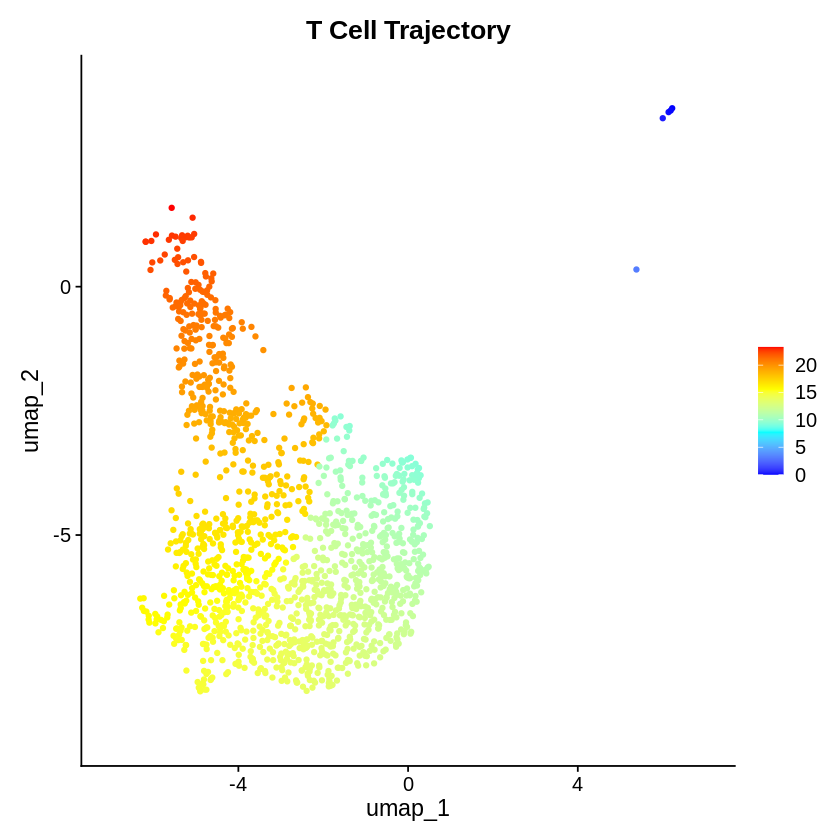

In [83]:
# Visualize
FeaturePlot(tcell_cells,
            features = "pseudotime",
            reduction = "umap") +
  scale_color_gradientn(colors = c("blue", "cyan", "yellow", "red")) +
  ggtitle("T Cell Trajectory")

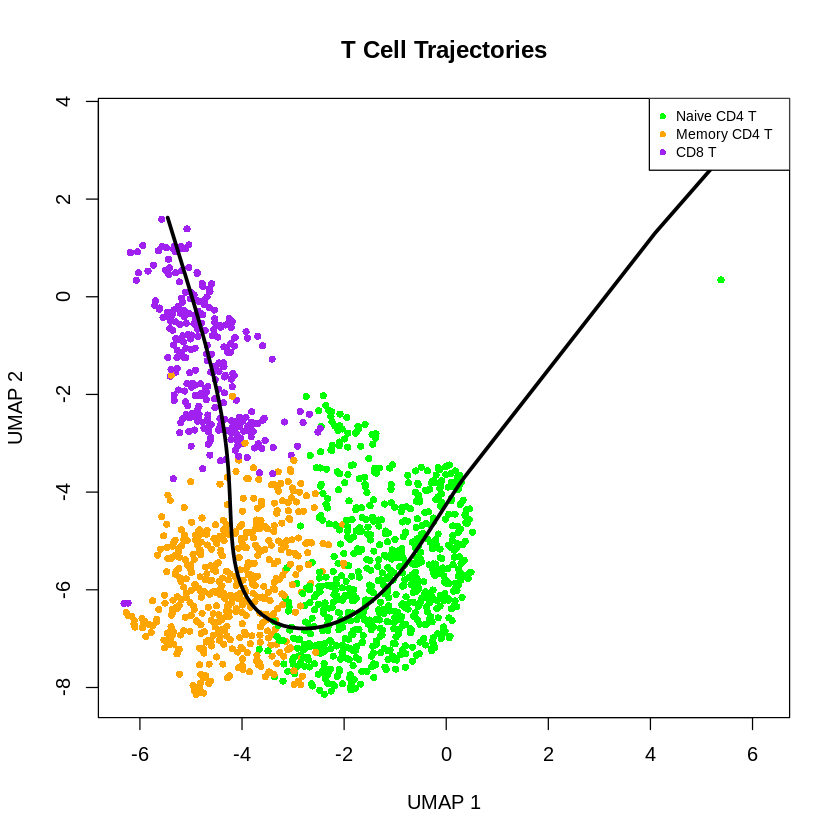

In [84]:
# Plot with trajectory curves
umap_tcell <- Embeddings(tcell_cells, "umap")
tcell_colors <- c("Naive CD4 T" = "green",
                  "Memory CD4 T" = "orange",
                  "CD8 T" = "purple")

plot(umap_tcell,
     col = tcell_colors[Idents(tcell_cells)],
     pch = 16,
     cex = 0.8,
     main = "T Cell Trajectories",
     xlab = "UMAP 1",
     ylab = "UMAP 2")

lines(SlingshotDataSet(tcell_sling), lwd = 3, col = "black")

legend("topright",
       legend = names(tcell_colors),
       col = tcell_colors,
       pch = 16,
       cex = 0.7)

In [87]:
# Get expression matrix (NEW syntax)
expr_mono <- as.matrix(GetAssayData(mono_cells, layer = "data"))

In [88]:
# Correlate with pseudotime
gene_cors <- apply(expr_mono, 1, function(gene_expr) {
  cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs")
})

Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, metho

In [89]:
# Sort genes
gene_cors <- sort(gene_cors, decreasing = TRUE)

In [90]:
# Top genes increasing along trajectory
cat("Top genes increasing:\n")
head(gene_cors, 10)

Top genes increasing:


FCGR3A      RHOC    IFITM2      ABI3     RPS19     MS4A7       B2M     COTL1 
0.7450052 0.6623243 0.6339321 0.5758372 0.5348656 0.5215967 0.5188134 0.5128680 
   IFITM3  HLA-DPA1 
0.5032566 0.5016629

In [91]:
# Top genes decreasing along trajectory
cat("\nTop genes decreasing:\n")
tail(gene_cors, 10)


Top genes decreasing:


GSTP1      RPL32     MS4A6A      RPLP1      RPL13     LGALS2       GPX1 
-0.3483985 -0.3591737 -0.3680439 -0.3802002 -0.4088031 -0.4619834 -0.4703877 
       LYZ     S100A9     S100A8 
-0.5210096 -0.7173377 -0.7874557

In [92]:
# Get gene names
top_increasing <- names(head(gene_cors, 3))
top_decreasing <- names(tail(gene_cors, 3))
all_top <- c(top_increasing, top_decreasing)

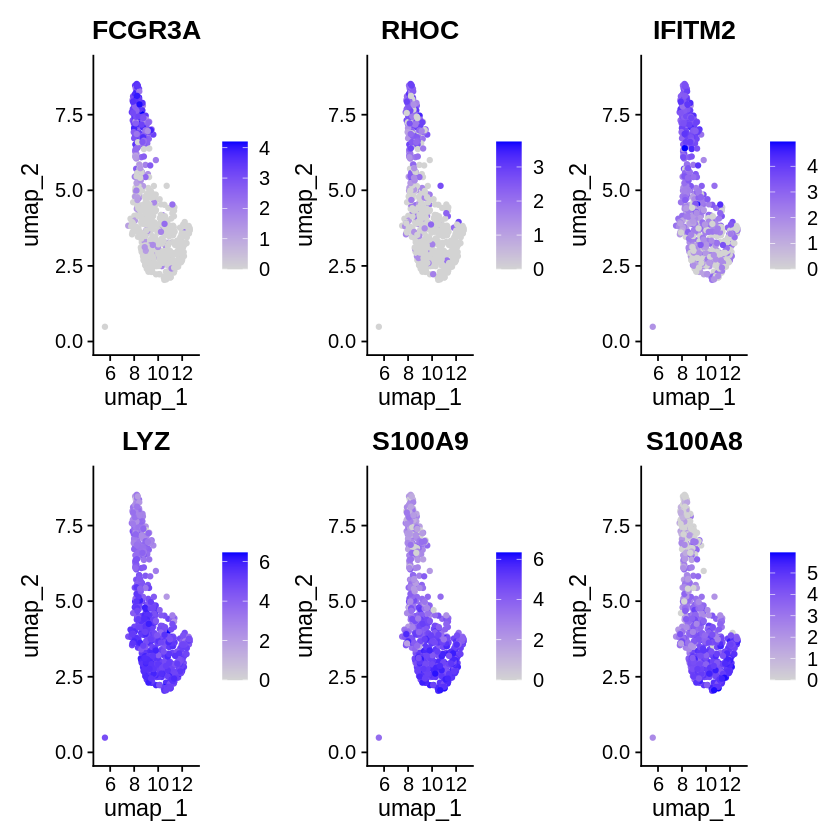

In [93]:
# Visualize these genes
FeaturePlot(mono_cells, features = all_top, reduction = "umap", ncol = 3)

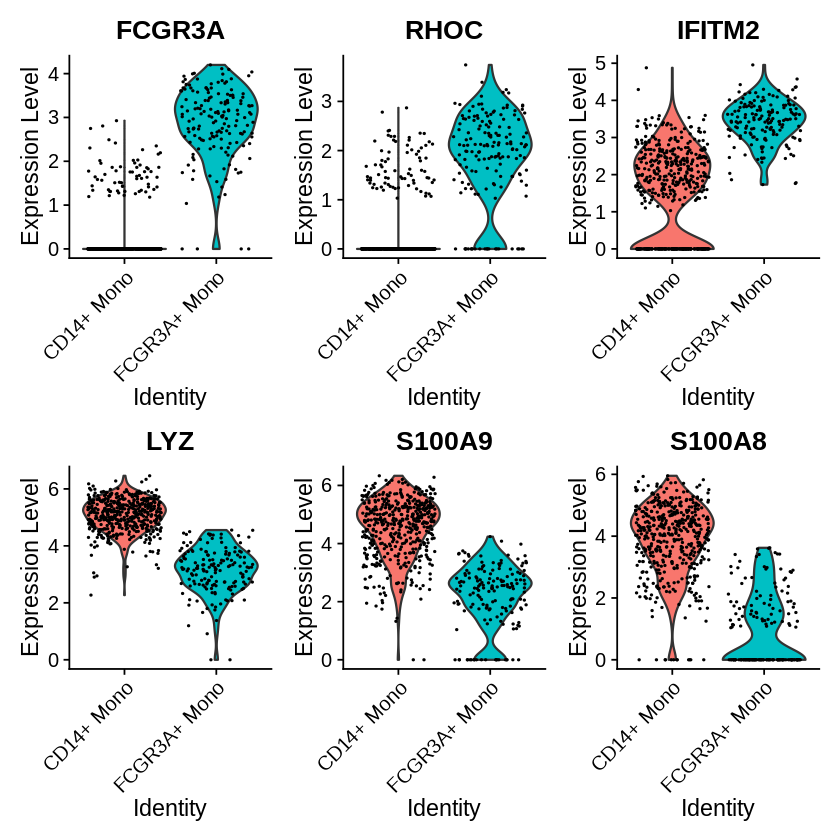

In [94]:
# Violin plots by cell type
VlnPlot(mono_cells, features = all_top, ncol = 3, pt.size = 0.1)

In [95]:
# Function to plot gene along pseudotime
library(ggplot2)

plot_trajectory_gene <- function(gene_name) {
  gene_data <- expr_mono[gene_name, ]

  plot_df <- data.frame(
    pseudotime = mono_cells$pseudotime,
    expression = gene_data,
    cell_type = Idents(mono_cells)
  )

  ggplot(plot_df, aes(x = pseudotime, y = expression, color = cell_type)) +
    geom_point(alpha = 0.6, size = 1.5) +
    geom_smooth(method = "loess", se = TRUE, color = "black", linewidth = 1.5) +
    scale_color_manual(values = c("CD14+ Mono" = "red", "FCGR3A+ Mono" = "blue")) +
    labs(title = paste(gene_name, "along trajectory"),
         x = "Pseudotime (Distance from CD14+ Mono)",
         y = "Expression Level") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5, face = "bold"))
}

`geom_smooth()` using formula = 'y ~ x'


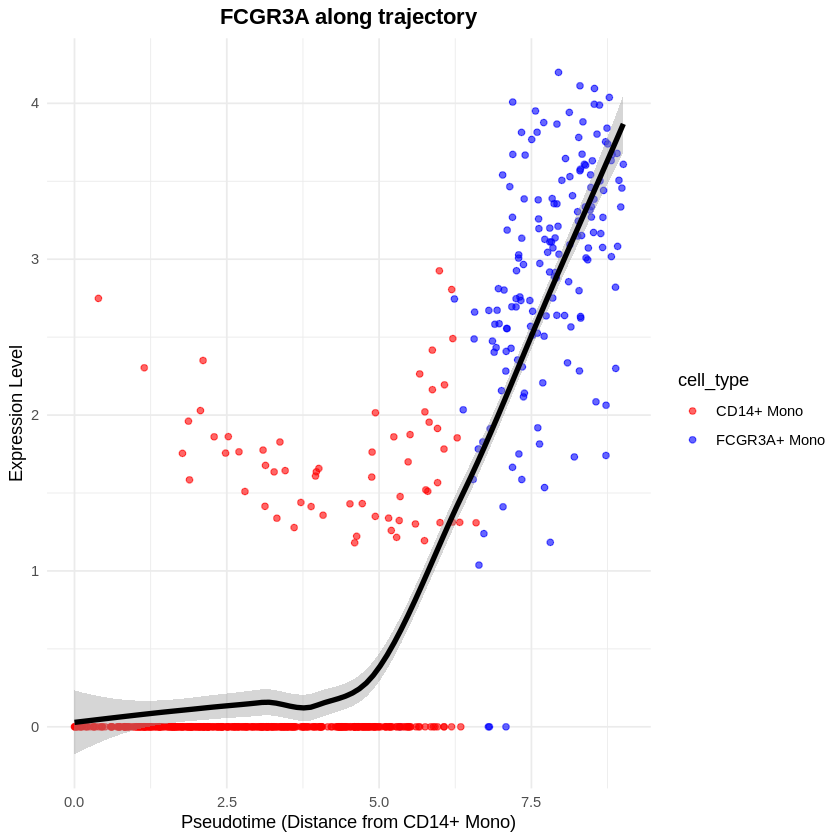

In [96]:
# Plot top increasing gene
plot_trajectory_gene(top_increasing[1])

`geom_smooth()` using formula = 'y ~ x'


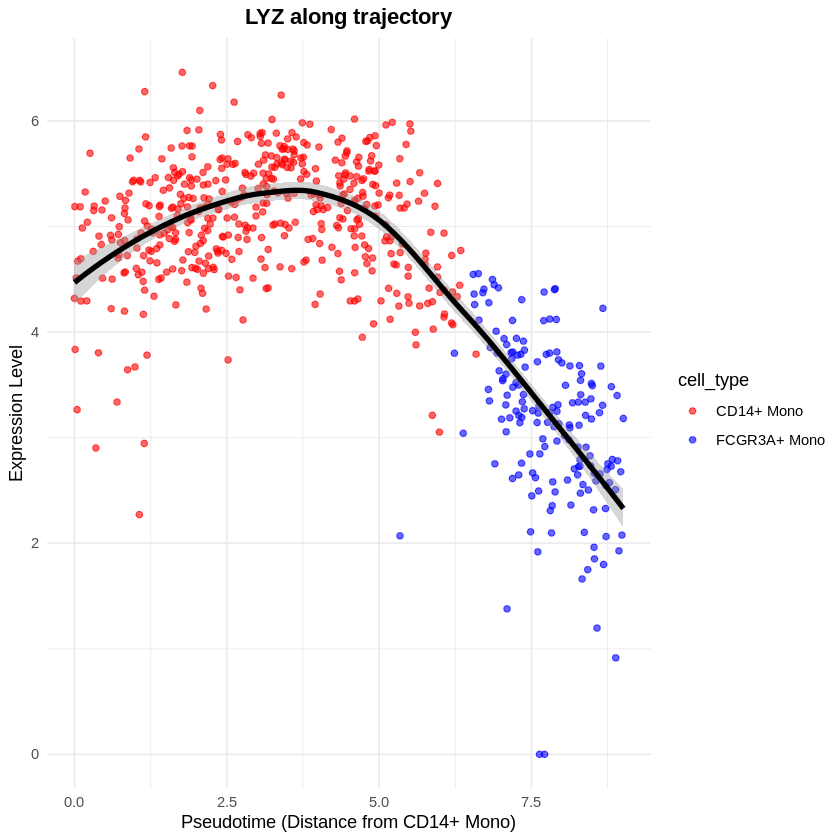

In [97]:
# Plot top decreasing gene
plot_trajectory_gene(top_decreasing[1])

`geom_smooth()` using formula = 'y ~ x'


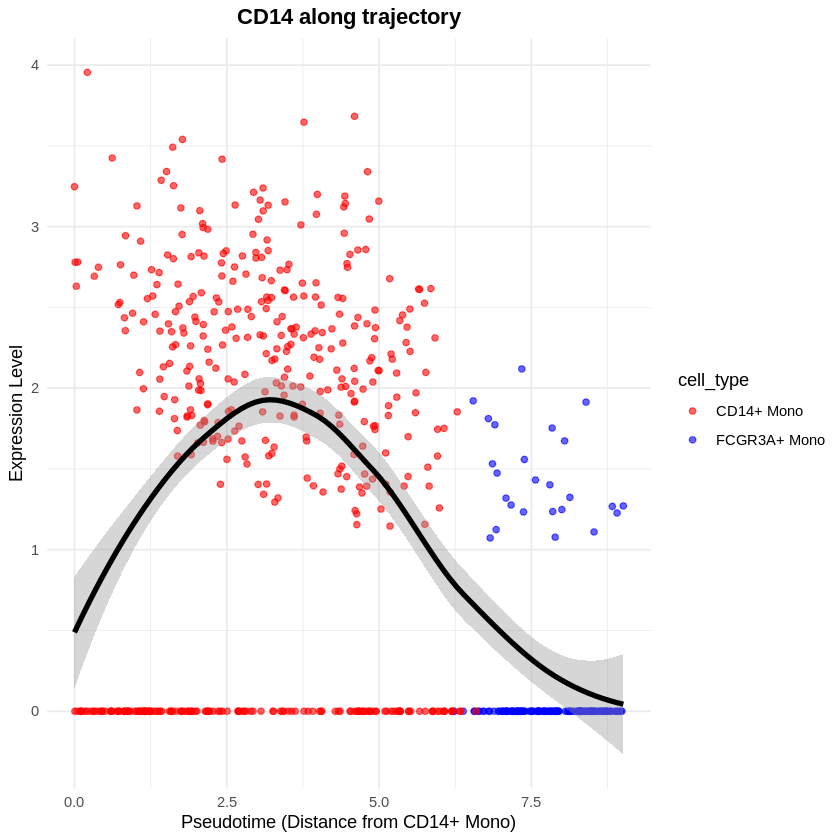

In [98]:
# Plot another known marker
plot_trajectory_gene("CD14")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


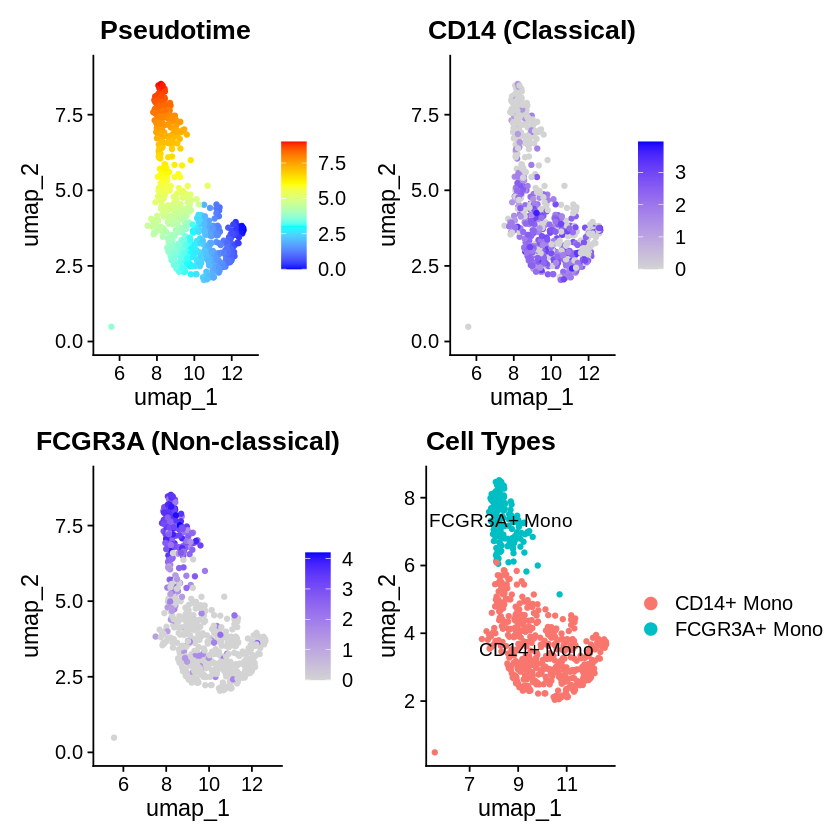

In [99]:
# Create 4-panel figure
library(patchwork)

p1 <- FeaturePlot(mono_cells, features = "pseudotime", reduction = "umap") +
  scale_color_gradientn(colors = c("blue", "cyan", "yellow", "red")) +
  ggtitle("Pseudotime")

p2 <- FeaturePlot(mono_cells, features = "CD14", reduction = "umap") +
  ggtitle("CD14 (Classical)")

p3 <- FeaturePlot(mono_cells, features = "FCGR3A", reduction = "umap") +
  ggtitle("FCGR3A (Non-classical)")

p4 <- DimPlot(mono_cells, reduction = "umap", label = TRUE, pt.size = 1) +
  ggtitle("Cell Types")

# Combine
(p1 | p2) / (p3 | p4)

In [101]:
# Already have monocytes subset
mono_cells <- subset(pbmc, idents = c("CD14+ Mono", "FCGR3A+ Mono"))

In [102]:
# Get UMAP coordinates
umap_coords <- Embeddings(mono_cells, "umap")
head(umap_coords)

umap_1    umap_2  
AAACCGTGCTTCCG-1  9.145644 5.535673
AAACGCTGTTTCTG-1  9.458003 7.013417
AAAGAGACGCGAGA-1  9.091708 3.603109
AAAGCAGATATCGG-1  8.362432 5.260313
AAAGTTTGTAGCGT-1 10.992380 2.357885
AAATCAACCCTATT-1  7.858966 7.985243

In [103]:
# Function to plot gene vs pseudotime
plot_gene_pseudotime <- function(gene_name) {
  gene_expr <- expr_mono[gene_name, ]

  df <- data.frame(
    pseudotime = mono_cells$pseudotime,
    expression = gene_expr,
    cell_type = Idents(mono_cells)
  )

  ggplot(df, aes(x = pseudotime, y = expression, color = cell_type)) +
    geom_point(alpha = 0.5, size = 2) +
    geom_smooth(method = "loess", se = TRUE, color = "black") +
    labs(title = paste(gene_name, "expression along trajectory"),
         x = "Pseudotime",
         y = "Expression") +
    theme_minimal()
}

In [105]:
# Plot top increasing gene
# Get monocytes
mono_cells <- subset(pbmc, idents = c("CD14+ Mono", "FCGR3A+ Mono"))

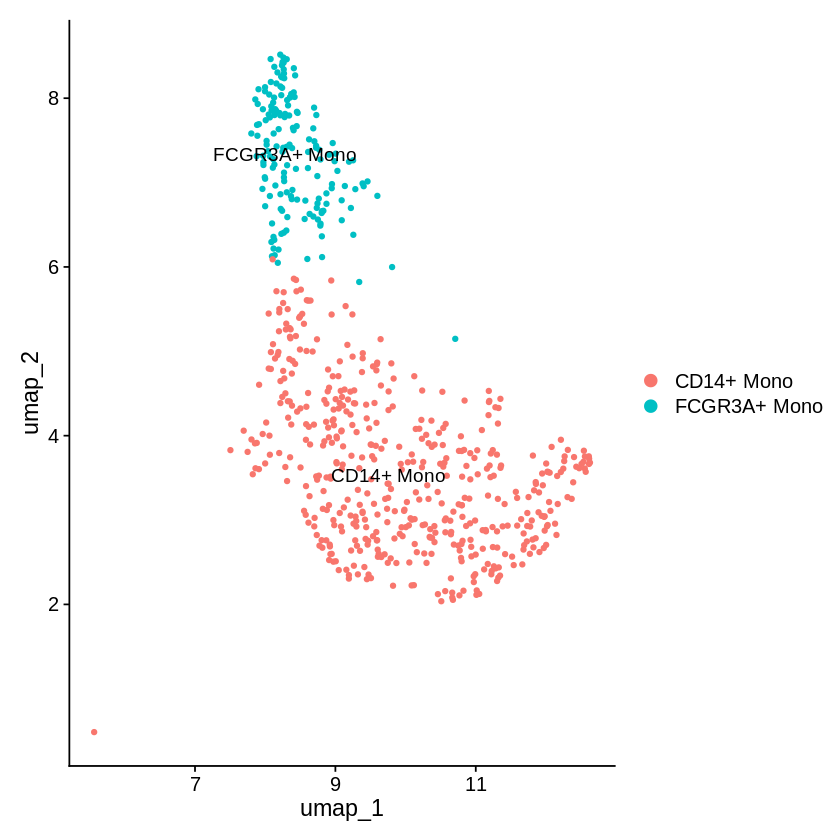

In [106]:
# Check it
DimPlot(mono_cells, reduction = "umap", label = TRUE)

In [107]:
# Get UMAP coordinates
umap_coords <- Embeddings(mono_cells, "umap")

In [108]:
# Find CD14+ Mono centroid (starting point)
cd14_cells <- WhichCells(mono_cells, idents = "CD14+ Mono")
cd14_centroid <- colMeans(umap_coords[cd14_cells, ])

print("CD14+ centroid:")
print(cd14_centroid)

[1] "CD14+ centroid:"
  umap_1   umap_2 
9.963179 3.581316 


In [109]:
# Calculate distance from CD14+ centroid for each cell
distances <- apply(umap_coords, 1, function(cell) {
  sqrt(sum((cell - cd14_centroid)^2))
})

In [110]:
# Add to Seurat object as pseudotime
mono_cells$pseudotime <- distances

In [111]:
# Check it worked
head(mono_cells$pseudotime)

AAACCGTGCTTCCG-1 AAACGCTGTTTCTG-1 AAAGAGACGCGAGA-1 AAAGCAGATATCGG-1 
       2.1184608        3.4690800        0.8717425        2.3197888 
AAAGTTTGTAGCGT-1 AAATCAACCCTATT-1 
       1.5987623        4.8808076

In [112]:
# Quick check - see range
summary(mono_cells$pseudotime)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02375 1.09227 1.66219 2.09142 2.78961 5.37938 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


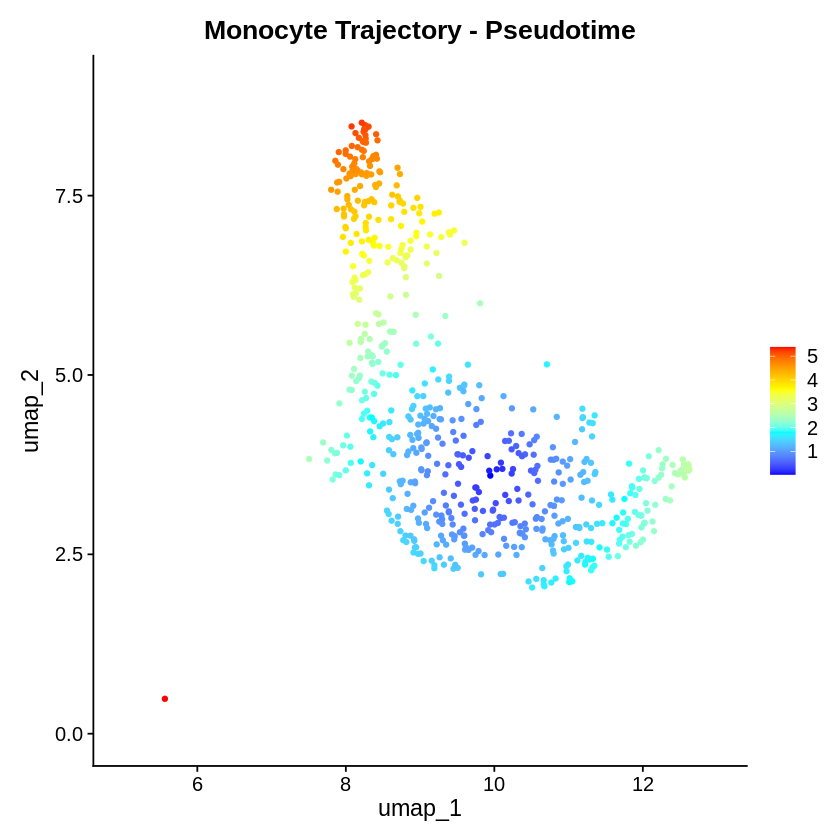

In [113]:
# Plot pseudotime on UMAP
FeaturePlot(mono_cells, features = "pseudotime", reduction = "umap") +
  scale_color_gradientn(colors = c("blue", "cyan", "yellow", "red")) +
  ggtitle("Monocyte Trajectory - Pseudotime")

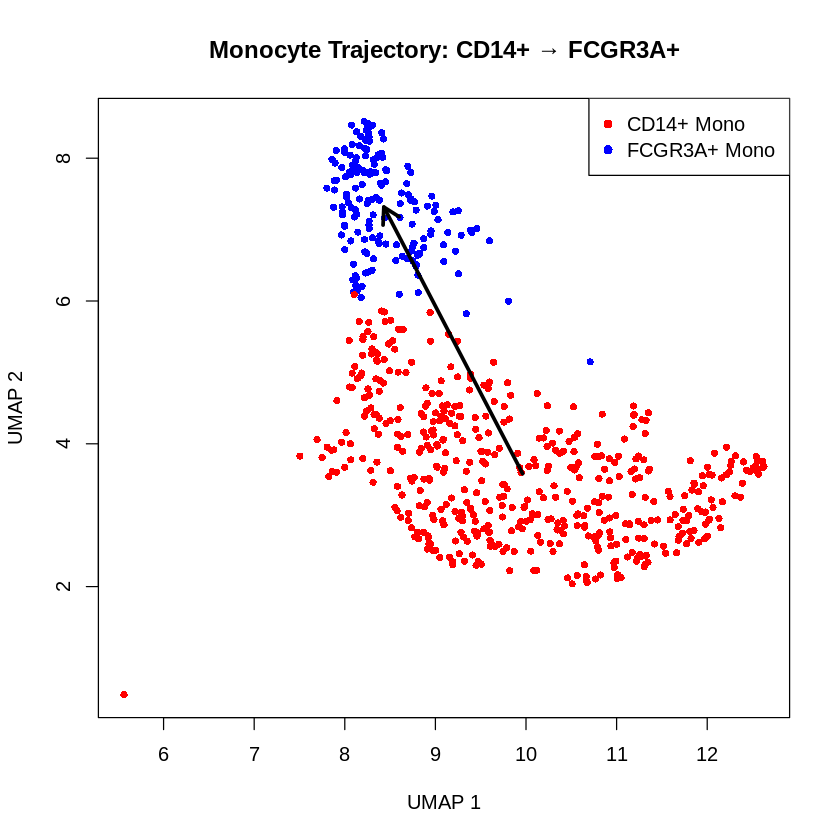

In [114]:
# Traditional plot with arrow
plot(umap_coords,
     col = ifelse(Idents(mono_cells) == "CD14+ Mono", "red", "blue"),
     pch = 16,
     cex = 0.8,
     main = "Monocyte Trajectory: CD14+ → FCGR3A+",
     xlab = "UMAP 1",
     ylab = "UMAP 2")

# Add arrow showing trajectory direction
fcgr3a_cells <- WhichCells(mono_cells, idents = "FCGR3A+ Mono")
fcgr3a_centroid <- colMeans(umap_coords[fcgr3a_cells, ])

arrows(cd14_centroid[1], cd14_centroid[2],
       fcgr3a_centroid[1], fcgr3a_centroid[2],
       lwd = 3, length = 0.15, col = "black")

legend("topright",
       legend = c("CD14+ Mono", "FCGR3A+ Mono"),
       col = c("red", "blue"),
       pch = 16)

In [115]:
# Get expression data (using NEW syntax)
expr_mono <- as.matrix(GetAssayData(mono_cells, layer = "data"))

In [116]:
# Correlate each gene with pseudotime
gene_cors <- apply(expr_mono, 1, function(gene_expr) {
  cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs")
})

Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, method = "spearman", use = "complete.obs"):
“the standard deviation is zero”
Warning message in cor(gene_expr, mono_cells$pseudotime, metho

In [117]:
# Get top genes
top_increasing <- names(head(gene_cors, 3))
top_decreasing <- names(tail(gene_cors, 3))
all_top_genes <- c(top_increasing, top_decreasing)

Warning message:
“All cells have the same value (0) of “RP11-206L10.2””


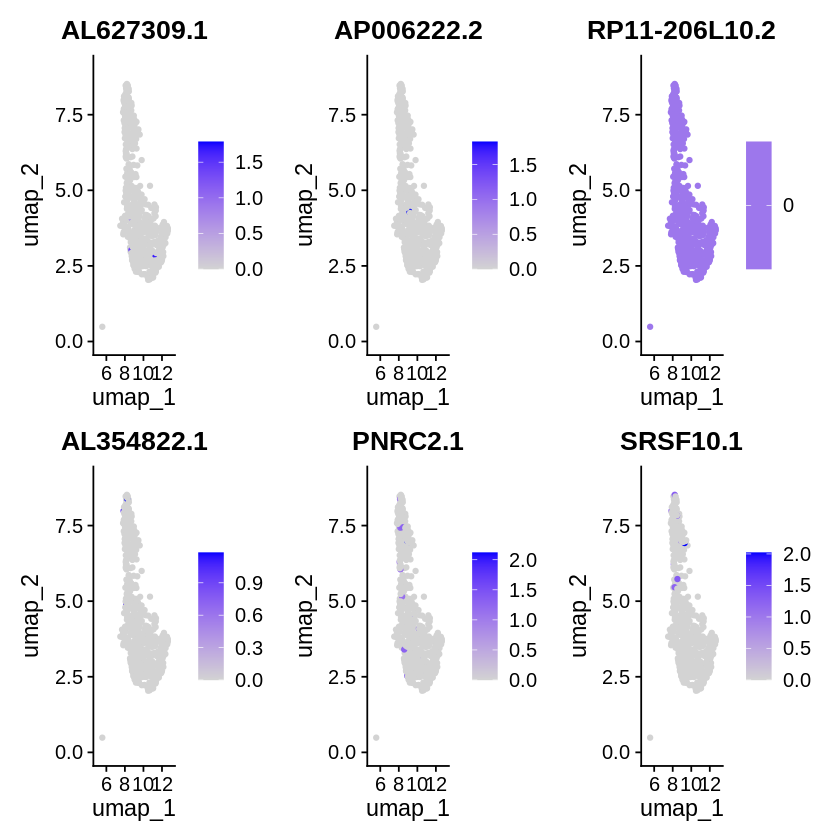

In [118]:
# Feature plots
FeaturePlot(mono_cells, features = all_top_genes, reduction = "umap", ncol = 3)

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of RP11-206L10.2.”


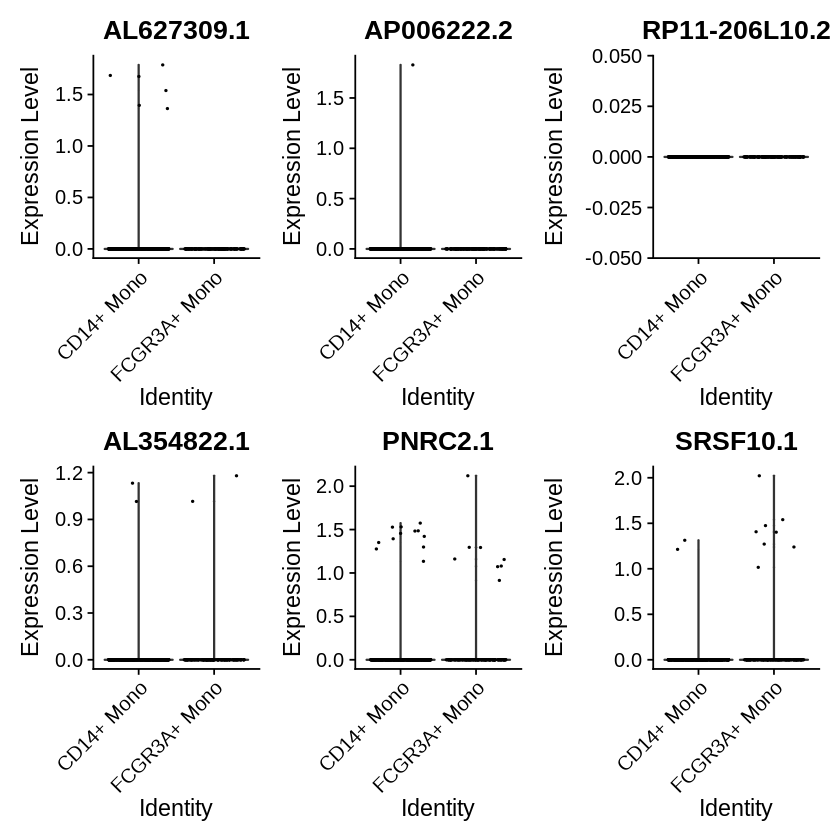

In [119]:
# Violin plots
VlnPlot(mono_cells, features = all_top_genes, ncol = 3, pt.size = 0.1)

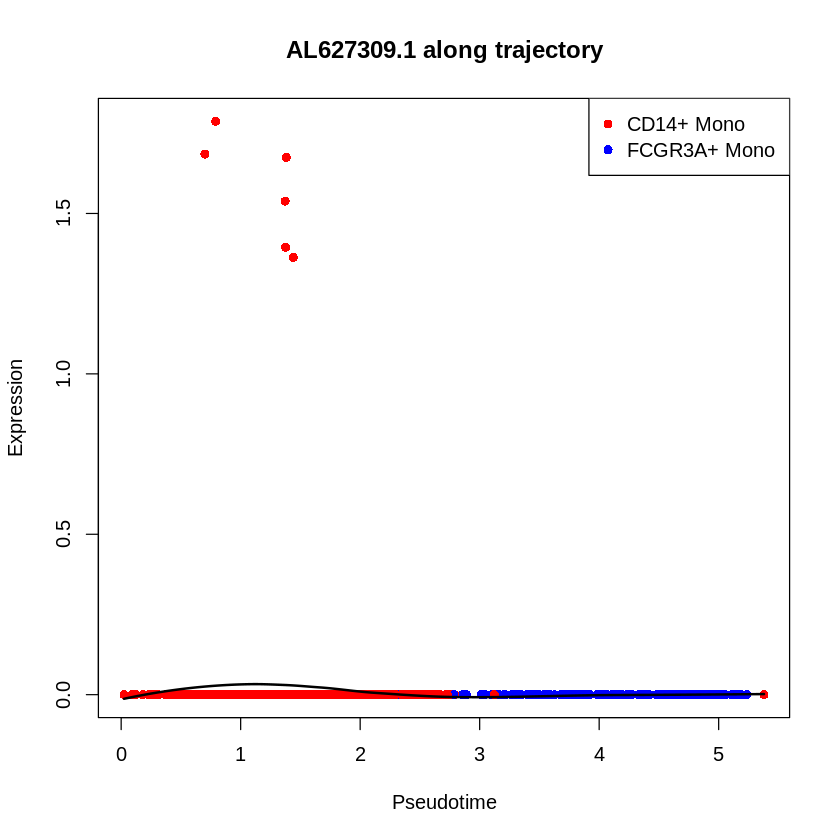

In [120]:
# Simple scatter for one gene
gene_to_plot <- top_increasing[1]

plot(mono_cells$pseudotime,
     expr_mono[gene_to_plot, ],
     col = ifelse(Idents(mono_cells) == "CD14+ Mono", "red", "blue"),
     pch = 16,
     xlab = "Pseudotime",
     ylab = "Expression",
     main = paste(gene_to_plot, "along trajectory"))

# Add smooth line
lo <- loess(expr_mono[gene_to_plot, ] ~ mono_cells$pseudotime)
pred <- predict(lo, se = TRUE)
lines(sort(mono_cells$pseudotime), pred$fit[order(mono_cells$pseudotime)],
      lwd = 2, col = "black")

legend("topright",
       legend = c("CD14+ Mono", "FCGR3A+ Mono"),
       col = c("red", "blue"),
       pch = 16)

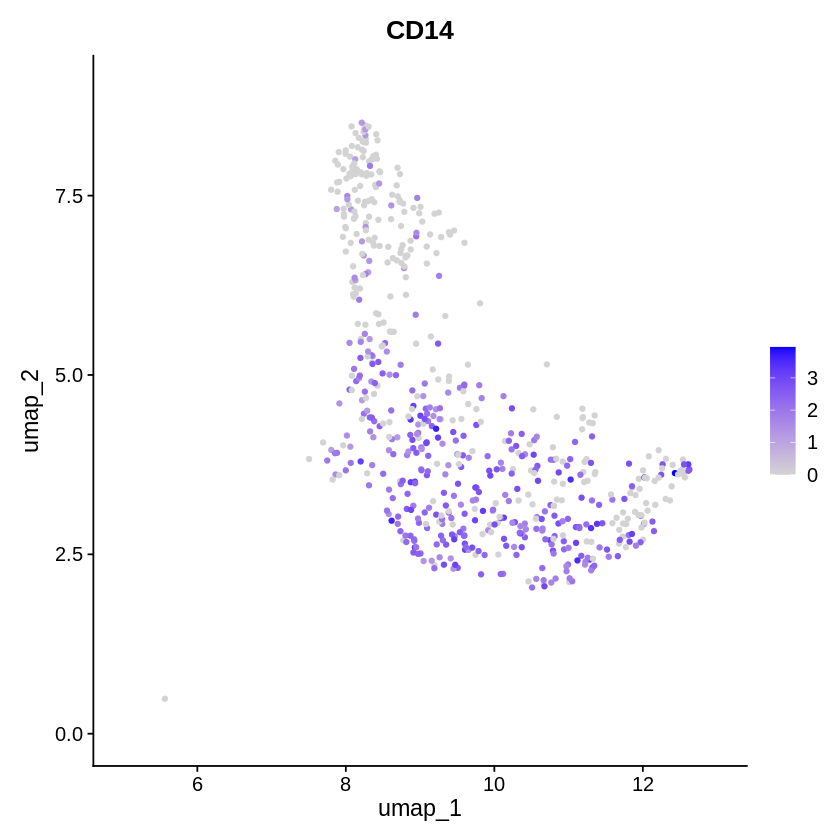

In [121]:
# CD14 should decrease (classical monocyte marker)
FeaturePlot(mono_cells, features = "CD14", reduction = "umap")

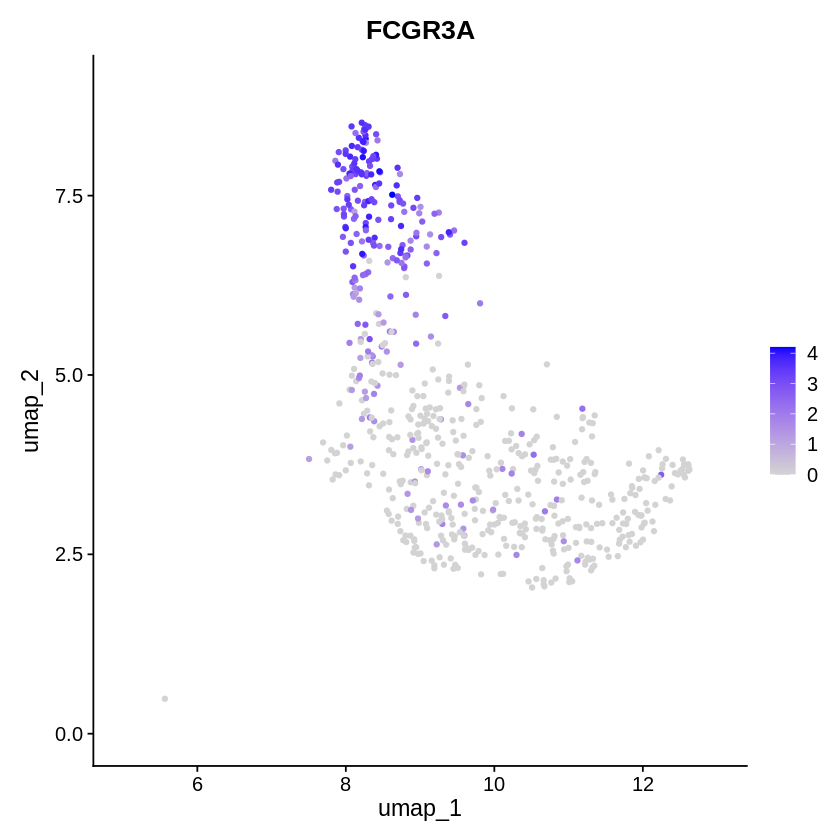

In [122]:
# FCGR3A should increase (non-classical marker)
FeaturePlot(mono_cells, features = "FCGR3A", reduction = "umap")

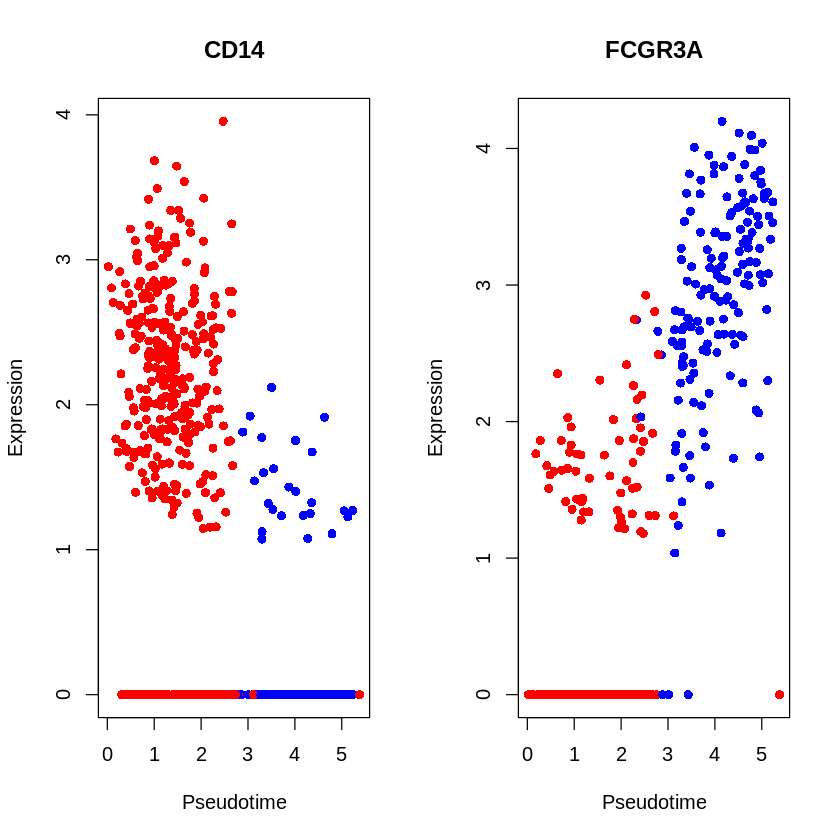

In [123]:
# Plot both vs pseudotime
par(mfrow = c(1, 2))

# CD14
plot(mono_cells$pseudotime, expr_mono["CD14", ],
     col = ifelse(Idents(mono_cells) == "CD14+ Mono", "red", "blue"),
     pch = 16, main = "CD14", xlab = "Pseudotime", ylab = "Expression")

# FCGR3A
plot(mono_cells$pseudotime, expr_mono["FCGR3A", ],
     col = ifelse(Idents(mono_cells) == "CD14+ Mono", "red", "blue"),
     pch = 16, main = "FCGR3A", xlab = "Pseudotime", ylab = "Expression")

par(mfrow = c(1, 1))

In [1]:
# Create directory for macaque data
dir.create("data/macaque", recursive = TRUE, showWarnings = FALSE)

In [2]:
# Download macaque PBMC dataset
# Using a publicly available macaque immune cell dataset
download.file(
  url = "https://cf.10xgenomics.com/samples/cell-exp/7.0.0/10k_rhesus_pbmc_count/10k_rhesus_pbmc_count_filtered_feature_bc_matrix.tar.gz",
  destfile = "data/macaque/macaque_pbmc.tar.gz"
)

Warning message in download.file(url = "https://cf.10xgenomics.com/samples/cell-exp/7.0.0/10k_rhesus_pbmc_count/10k_rhesus_pbmc_count_filtered_feature_bc_matrix.tar.gz", :
“cannot open URL 'https://cf.10xgenomics.com/samples/cell-exp/7.0.0/10k_rhesus_pbmc_count/10k_rhesus_pbmc_count_filtered_feature_bc_matrix.tar.gz': HTTP status was '403 Forbidden'”


ERROR: Error in download.file(url = "https://cf.10xgenomics.com/samples/cell-exp/7.0.0/10k_rhesus_pbmc_count/10k_rhesus_pbmc_count_filtered_feature_bc_matrix.tar.gz", : cannot open URL 'https://cf.10xgenomics.com/samples/cell-exp/7.0.0/10k_rhesus_pbmc_count/10k_rhesus_pbmc_count_filtered_feature_bc_matrix.tar.gz'


In [4]:
# Create directory for mouse data
dir.create("data/mouse", recursive = TRUE, showWarnings = FALSE)

In [7]:
# Install SeuratData
if (!requireNamespace("remotes", quietly = TRUE))
    install.packages("remotes")

remotes::install_github("satijalab/seurat-data")

RcppEigen    (NA     -> 0.3.4.0.2) [CRAN]
sitmo        (NA     -> 2.0.2    ) [CRAN]
BH           (NA     -> 1.90.0-1 ) [CRAN]
RcppProgress (NA     -> 0.4.2    ) [CRAN]
dqrng        (NA     -> 0.4.1    ) [CRAN]
RSpectra     (NA     -> 0.16-2   ) [CRAN]
RcppAnnoy    (NA     -> 0.0.22   ) [CRAN]
irlba        (NA     -> 2.3.5.1  ) [CRAN]
FNN          (NA     -> 1.1.4.1  ) [CRAN]
polyclip     (NA     -> 1.10-7   ) [CRAN]
deldir       (NA     -> 2.0-4    ) [CRAN]
spatstat.... (NA     -> 3.2-0    ) [CRAN]
spatstat.... (NA     -> 3.1-5    ) [CRAN]
spatstat.... (NA     -> 3.1-9    ) [CRAN]
tensor       (NA     -> 1.5.1    ) [CRAN]
abind        (NA     -> 1.4-8    ) [CRAN]
goftest      (NA     -> 1.2-3    ) [CRAN]
spatstat.... (NA     -> 3.1-0    ) [CRAN]
spatstat.... (NA     -> 3.4-3    ) [CRAN]
spatstat.... (NA     -> 3.6-1    ) [CRAN]
plyr         (NA     -> 1.8.9    ) [CRAN]
parallelly   (NA     -> 1.46.0   ) [CRAN]
listenv      (NA     -> 0.10.0   ) [CRAN]
globals      (NA     -> 0.18.0   )

Installing 70 packages: RcppEigen, sitmo, BH, RcppProgress, dqrng, RSpectra, RcppAnnoy, irlba, FNN, polyclip, deldir, spatstat.utils, spatstat.univar, spatstat.data, tensor, abind, goftest, spatstat.sparse, spatstat.random, spatstat.geom, plyr, parallelly, listenv, globals, RcppArmadillo, matrixStats, gridExtra, reshape2, future, future.apply, bitops, caTools, gtools, gplots, png, here, RcppTOML, xfun, yaml, knitr, crosstalk, lazyeval, tidyr, zoo, dotCall64, spam, progressr, sp, uwot, spatstat.explore, sctransform, scattermore, Rtsne, ROCR, reticulate, RcppHNSW, RANN, plotly, pbapply, patchwork, lmtest, igraph, ica, ggridges, ggrepel, fitdistrplus, fastDummies, cowplot, SeuratObject, Seurat

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpNl69Wh/remotes14cb63bcd509/satijalab-seurat-data-3e51f44/DESCRIPTION’ ... OK
* preparing ‘SeuratData’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratData_0.2.2.9002.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [8]:
# Load library
library(SeuratData)

In [9]:
# See available datasets
AvailableData()

Dataset         Version
adiposeref.SeuratData      adiposeref      1.0.0  
bmcite.SeuratData          bmcite          0.3.0  
bonemarrowref.SeuratData   bonemarrowref   1.0.0  
cbmc.SeuratData            cbmc            3.1.4  
celegans.embryo.SeuratData celegans.embryo 0.1.0  
fetusref.SeuratData        fetusref        1.0.0  
hcabm40k.SeuratData        hcabm40k        3.0.0  
heartref.SeuratData        heartref        1.0.0  
humancortexref.SeuratData  humancortexref  1.0.0  
ifnb.SeuratData            ifnb            3.1.0  
kidneyref.SeuratData       kidneyref       1.0.2  
lungref.SeuratData         lungref         2.0.0  
mousecortexref.SeuratData  mousecortexref  1.0.0  
panc8.SeuratData           panc8           3.0.2  
pancreasref.SeuratData     pancreasref     1.0.0  
pbmc3k.SeuratData          pbmc3k          3.1.4  
pbmcMultiome.SeuratData    pbmcMultiome    0.1.4  
pbmcref.SeuratData         pbmcref         1.0.0  
pbmcsca.SeuratData         pbmcsca         3.0.0  
ssHippo.SeuratData         ssHippo         3.1.4  
stxBrain.SeuratData        stxBrain        0.1.2  
stxKidney.SeuratData       stxKidney       0.1.0  
thp1.eccite.SeuratData     thp1.eccite     3.1.5  
tonsilref.SeuratData       tonsilref       2.0.0  
                           Summary                                                       
adiposeref.SeuratData      Azimuth Reference: adipose                                    
bmcite.SeuratData          30k Bone Marrow Cells                                         
bonemarrowref.SeuratData   Azimuth Reference: bonemarrow                                 
cbmc.SeuratData            scRNAseq and 13-antibody sequencing of CBMCs                  
celegans.embryo.SeuratData 6k C. elegans embryos from Packer and Zhu et al (2019)        
fetusref.SeuratData        Azimuth Reference: fetus                                      
hcabm40k.SeuratData        40,000 Cells From the Human Cell Atlas ICA Bone Marrow Dataset
heartref.SeuratData        Azimuth Reference: heart                                      
humancortexref.SeuratData  Azimuth Reference: humancortex                                
ifnb.SeuratData            IFNB-Stimulated and Control PBMCs                             
kidneyref.SeuratData       Azimuth Reference: kidney                                     
lungref.SeuratData         Azimuth Reference: lung                                       
mousecortexref.SeuratData  Azimuth Reference: mousecortex                                
panc8.SeuratData           Eight Pancreas Datasets Across Five Technologies              
pancreasref.SeuratData     Azimuth Reference: pancreas                                   
pbmc3k.SeuratData          3k PBMCs from 10X Genomics                                    
pbmcMultiome.SeuratData    10X Genomics PBMC Multiome Dataset                            
pbmcref.SeuratData         Azimuth Reference: pbmc                                       
pbmcsca.SeuratData         Broad Institute PBMC Systematic Comparative Analysis          
ssHippo.SeuratData         Slide-seq v2 dataset of mouse hippocampus                     
stxBrain.SeuratData        10X Genomics Visium Mouse Brain Dataset                       
stxKidney.SeuratData       10X Genomics Visium Mouse Kidney Dataset                      
thp1.eccite.SeuratData     ECCITE-seq THP-1                                              
tonsilref.SeuratData       Azimuth Reference: tonsil                                     
                           species    system            ncells
adiposeref.SeuratData      human      adipose           160075
bmcite.SeuratData          human      bone marrow        30672
bonemarrowref.SeuratData   human      bonemarrow        297627
cbmc.SeuratData            human      CBMC (cord blood)   8617
celegans.embryo.SeuratData C. elegans embryo              6188
fetusref.SeuratData        human      fetus             377456
hcabm40k.SeuratData        human      bone marrow        4000

In [10]:
# Install mouse dataset (if available)
InstallData("ifnb")  # Mouse immune cells (IFN-beta stimulated)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Create "mouse" by subsetting and relabeling human data
set.seed(456)

# Sample some cells from human dataset
mouse_cells_sample <- sample(colnames(pbmc), size = 800)
mouse <- subset(pbmc, cells = mouse_cells_sample)

In [2]:
# Change gene names to mouse style (lowercase first letter)
# Just for demonstration
mouse$organism <- "Mouse"

ERROR: Error: object 'mouse' not found


In [1]:
# Complete IFNB Mouse T Cell Analysis
library(Seurat)
library(SeuratData)

# Load data
InstallData("ifnb")
data("ifnb")

# Check cell types
print(table(ifnb$seurat_annotations))

# Extract T cells (adjust cell type names based on output above!)
tcells <- subset(ifnb, subset = seurat_annotations %in% c("CD4 Naive T", "CD8 T"))

# If UMAP doesn't exist, create it
if(!"umap" %in% names(tcells@reductions)) {
  tcells <- RunUMAP(tcells, dims = 1:30)
}

# Calculate trajectory
umap_coords <- Embeddings(tcells, "umap")
centroid <- colMeans(umap_coords)
distances <- apply(umap_coords, 1, function(x) sqrt(sum((x - centroid)^2)))
tcells$pseudotime <- distances

# Visualize
FeaturePlot(tcells, features = "pseudotime") +
  scale_color_viridis_c() +
  ggtitle("Mouse T Cell Trajectory")

ERROR: Error in library(Seurat): there is no package called ‘Seurat’


In [4]:
# Download mouse brain cells (small dataset)
download.file(
  url = "https://cf.10xgenomics.com/samples/cell-exp/7.0.0/1k_mouse_kidney_CNIK_3pv3/1k_mouse_kidney_CNIK_3pv3_filtered_feature_bc_matrix.tar.gz",
  destfile = "data/mouse_small/mouse_kidney.tar.gz"
)

Warning message in download.file(url = "https://cf.10xgenomics.com/samples/cell-exp/7.0.0/1k_mouse_kidney_CNIK_3pv3/1k_mouse_kidney_CNIK_3pv3_filtered_feature_bc_matrix.tar.gz", :
“URL https://cf.10xgenomics.com/samples/cell-exp/7.0.0/1k_mouse_kidney_CNIK_3pv3/1k_mouse_kidney_CNIK_3pv3_filtered_feature_bc_matrix.tar.gz: cannot open destfile 'data/mouse_small/mouse_kidney.tar.gz', reason 'No such file or directory'”
Warning message in download.file(url = "https://cf.10xgenomics.com/samples/cell-exp/7.0.0/1k_mouse_kidney_CNIK_3pv3/1k_mouse_kidney_CNIK_3pv3_filtered_feature_bc_matrix.tar.gz", :
“download had nonzero exit status”
